In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline


In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

#this will cause text to be exported as 'true text' which can be edited in Adobe Illustrator
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [3]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_FIGURES_matrix'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_2way_sig', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'sig_vs_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [5]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [8]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=5, color=colors)
    return sig_value, p

In [9]:
def add_2way_sig(ax, sess, epoch, x, y, thresholds=(0.05, 0.01, 0.001)):
    p_reg = eval("%s_%s_pvals['region'][0]"%(epoch,sess))
    p_per = eval("%s_%s_pvals['period'][0]"%(epoch,sess))
    p_interac = eval("%s_%s_pvals['interaction'][0]"%(epoch,sess))
    for tex,i,ps in zip(('region','period','r X p   '),(8,4,0),(p_reg,p_per,p_interac)):
        ax.text(x, y+i, tex+': '+
            ('n.s.' if ps>thresholds[0] else
            '*' if ps>thresholds[1] else
            '**' if ps>thresholds[2] else
            '***'),
            ha='left', fontsize=3.5)
    return p

In [10]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [120]:
sessions = 'expo', 'pre', 'd2','post', 'ext1', 'ext2', 'renew'
dark_co = ('forestgreen','darkcyan','tab:purple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Day2','Late','Ext1','Ext','Reacquisition')

In [11]:
for r in ['dhpc']:
    #exec("distinct_%s = {}"%r)
    exec("distinct_%s = ut.load_variable('distinct',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))
    exec("distinct_ttest_%s = ut.load_variable('distinct_ttest',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))
    exec("distinct_wilcox_%s = ut.load_variable('distinct_wilcox',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))

In [11]:
for r in ['vhpc']:
    #exec("distinct_%s = {}"%r)
    exec("distinct_%s = ut.load_variable('distinct',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))
    exec("distinct_ttest_%s = ut.load_variable('distinct_ttest',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))
    exec("distinct_wilcox_%s = ut.load_variable('distinct_wilcox',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))

In [12]:
for r in ['dhpc']:
    #exec("distinct_%s = {}"%r)
    exec("distinct_mean_%s = ut.load_variable('distinct_mean',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))
    exec("distinct_mean_ttest_%s = ut.load_variable('distinct_mean_ttest',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))
    exec("distinct_mean_wilcox_%s = ut.load_variable('distinct_mean_wilcox',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(r,r))

In [13]:
for r in ['vhpc']:
    #exec("distinct_%s = {}"%r)
    exec("distinct_mean_%s = ut.load_variable('distinct_mean',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))
    exec("distinct_mean_ttest_%s = ut.load_variable('distinct_mean_ttest',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))
    exec("distinct_mean_wilcox_%s = ut.load_variable('distinct_mean_wilcox',\
        '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(r,r))

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


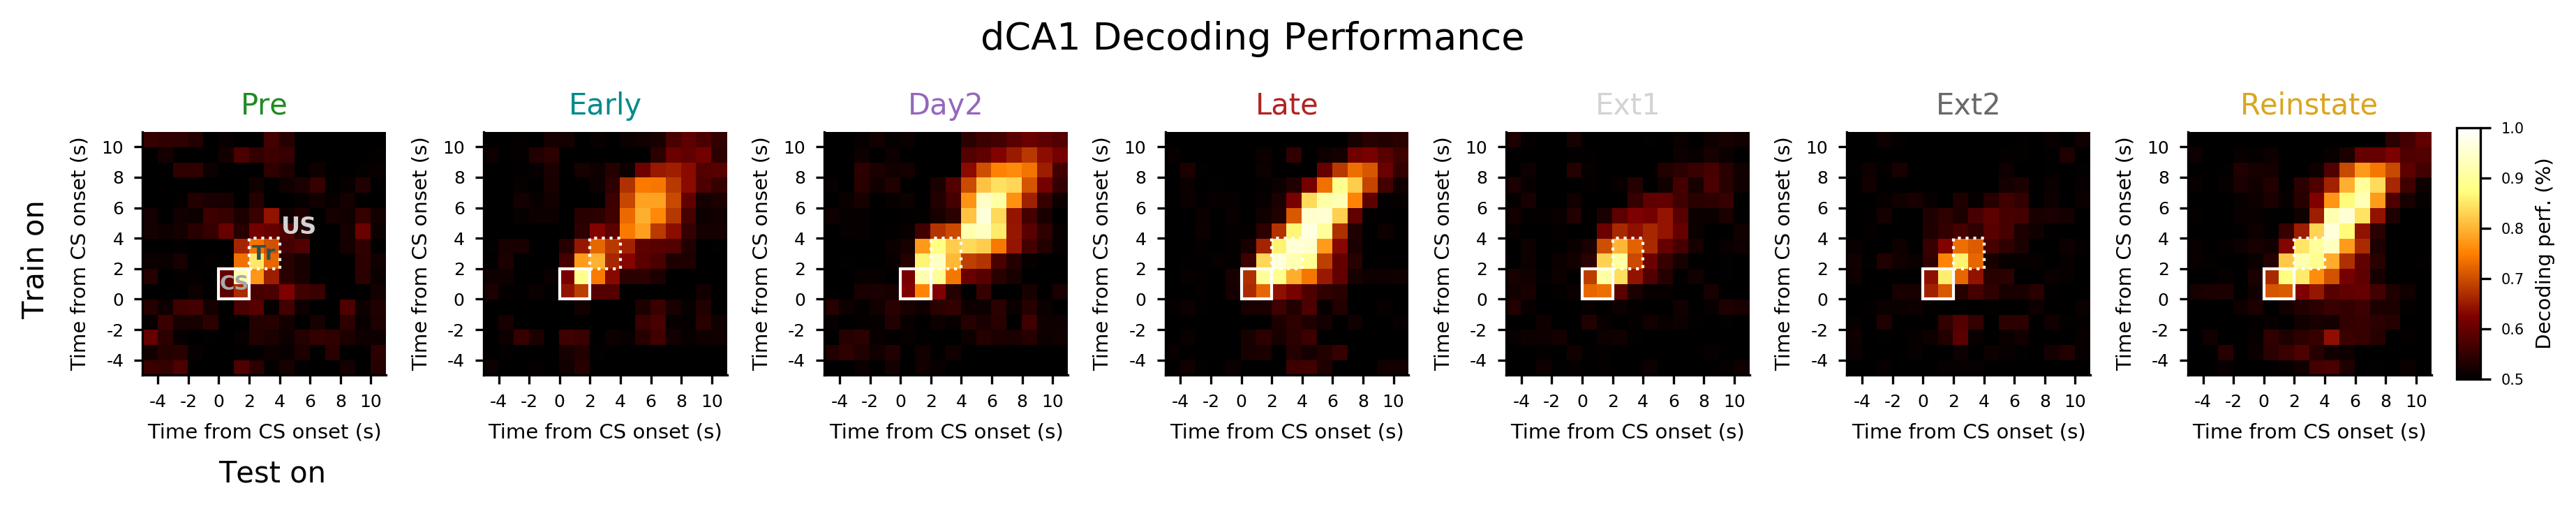

In [14]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_dhpc[sess],vmin=vmin, vmax=vmax,cmap='afmhot')
    ax[x].axis('image')
for x in range (0,7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    #ax[x].set_ylim(3, 15)
    #ax[x].set_xlim(3, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0].text(5,-7,"Test on", fontsize=10)
ax[0].text(-8,10,"Train on", fontsize=10, rotation=90)

pl.suptitle('dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_distinct_dCA1.pdf'%NOTEBOOK_NAME)

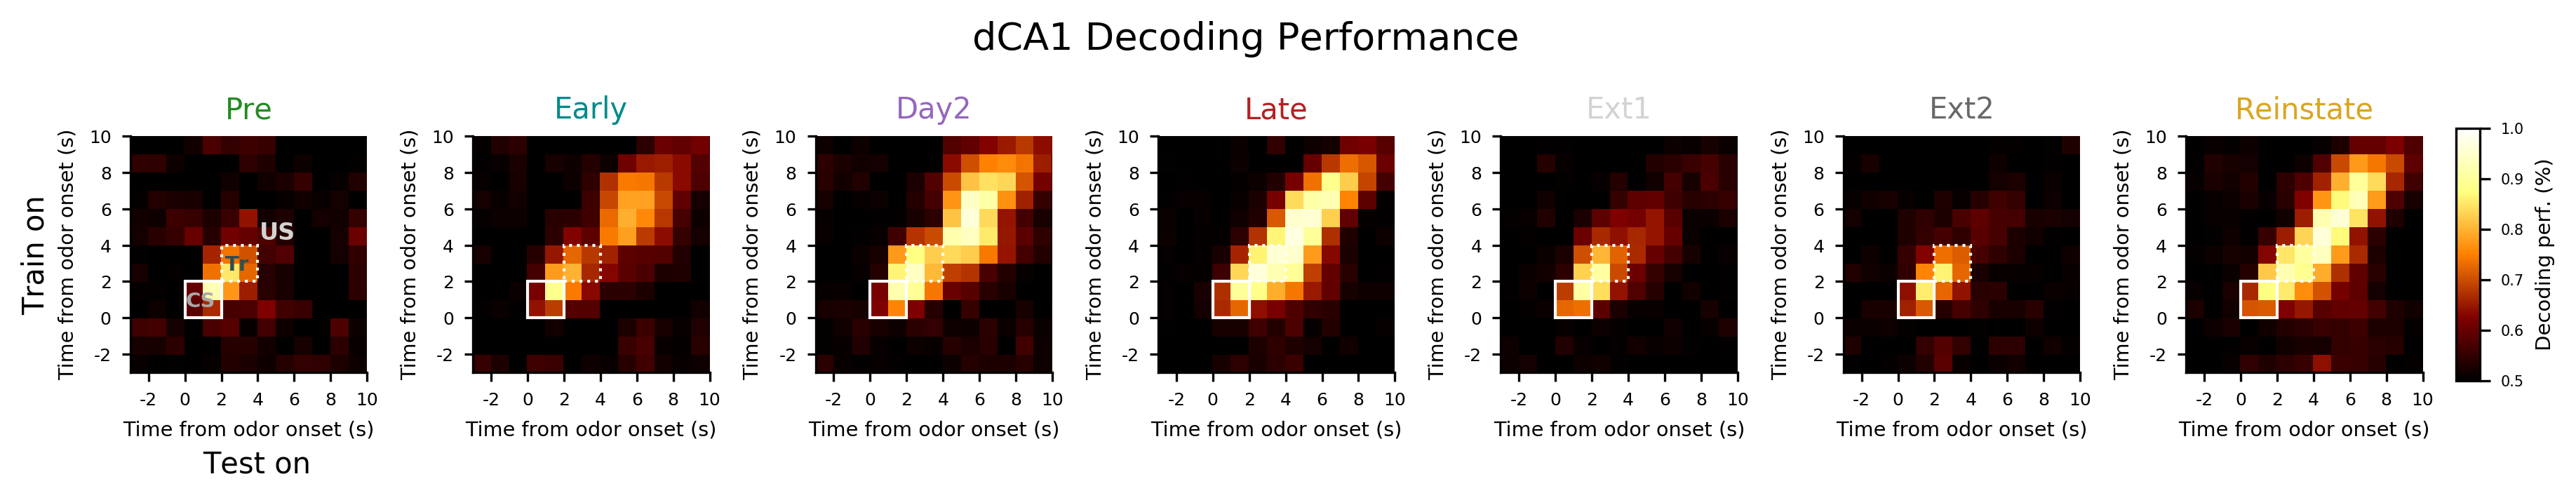

In [15]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_dhpc[sess],vmin=vmin, vmax=vmax,cmap='afmhot')
    ax[x].axis('image')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dCA1.pdf'%NOTEBOOK_NAME)

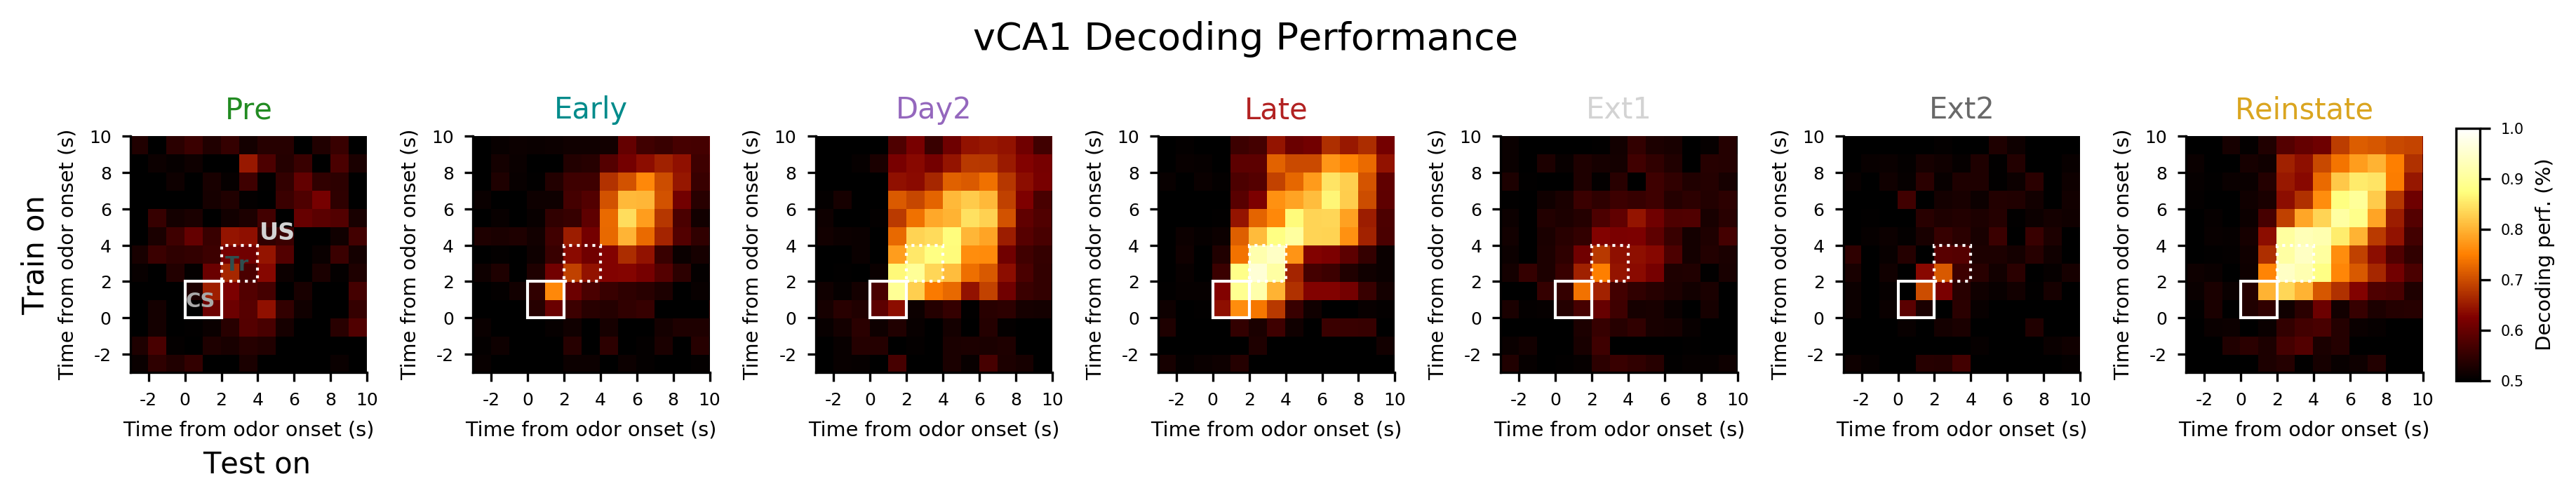

In [16]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_vhpc[sess],vmin=vmin, vmax=vmax,cmap='afmhot')
    ax[x].axis('image')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_vCA1.pdf'%NOTEBOOK_NAME)

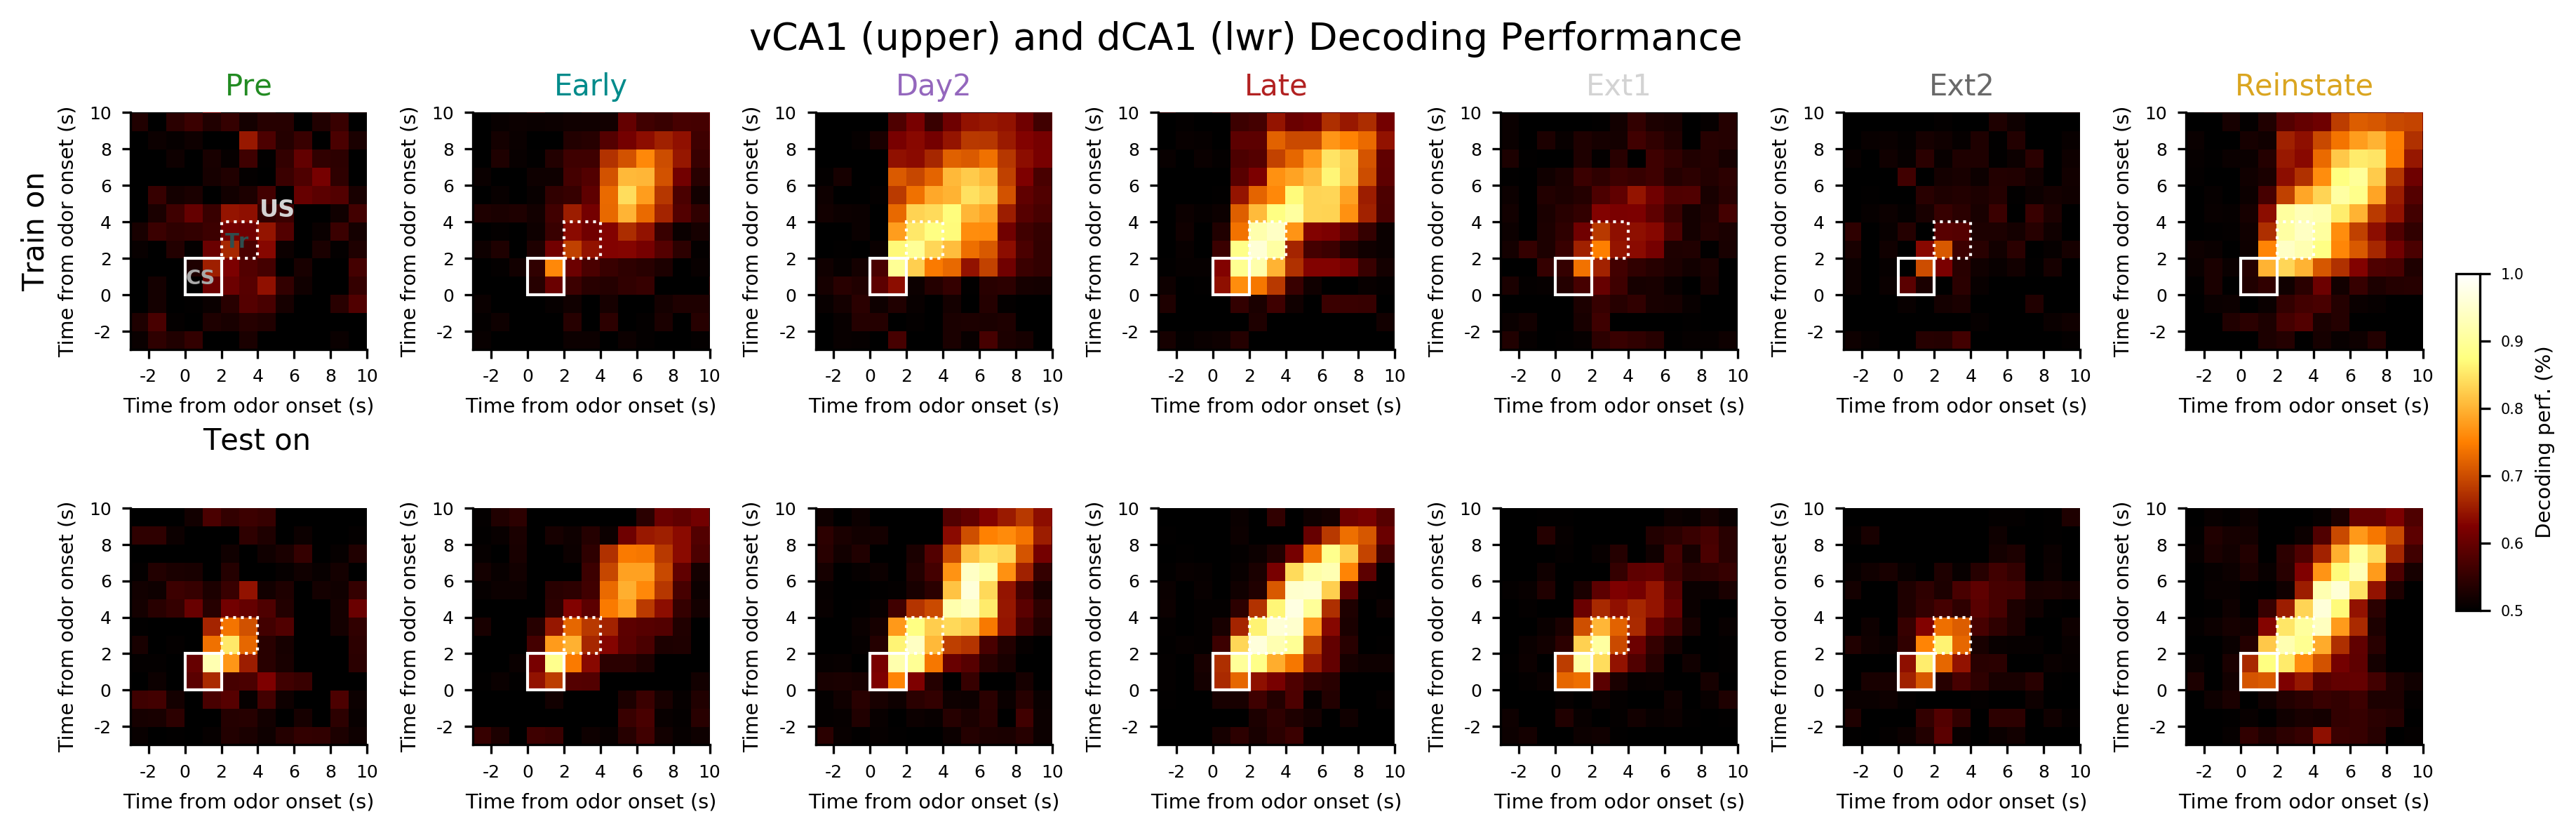

In [17]:
fig, ax = pl.subplots(2, 7, figsize=(11.5, 4))#, sharex=True, sharey=True)vmin=0.5
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for reg, y in zip (['vhpc','dhpc'],range(2)):
        im = ax[y][x].pcolormesh(eval("distinct_%s[sess]"%reg),vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[y][x].axis('image')
for x in range (7):
    for y in range (2):
        ax[y][x].set_xticks(range(1,16,2))
        ax[y][x].set_yticks(range(1,16,2))
        ax[y][x].set_ylim(2, 15)
        ax[y][x].set_xlim(2, 15)
        ax[y][x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
        ax[y][x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
        ax[0][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[y][x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
    for y in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[y][x].add_patch(CS)
        ax[y][x].add_patch(Tr)

ax[0][0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0][0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0][0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0][0].text(6,-3.5,"Test on", fontsize=10)
ax[0][0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 (upper) and dCA1 (lwr) Decoding Performance',y=1,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dv.pdf'%NOTEBOOK_NAME)

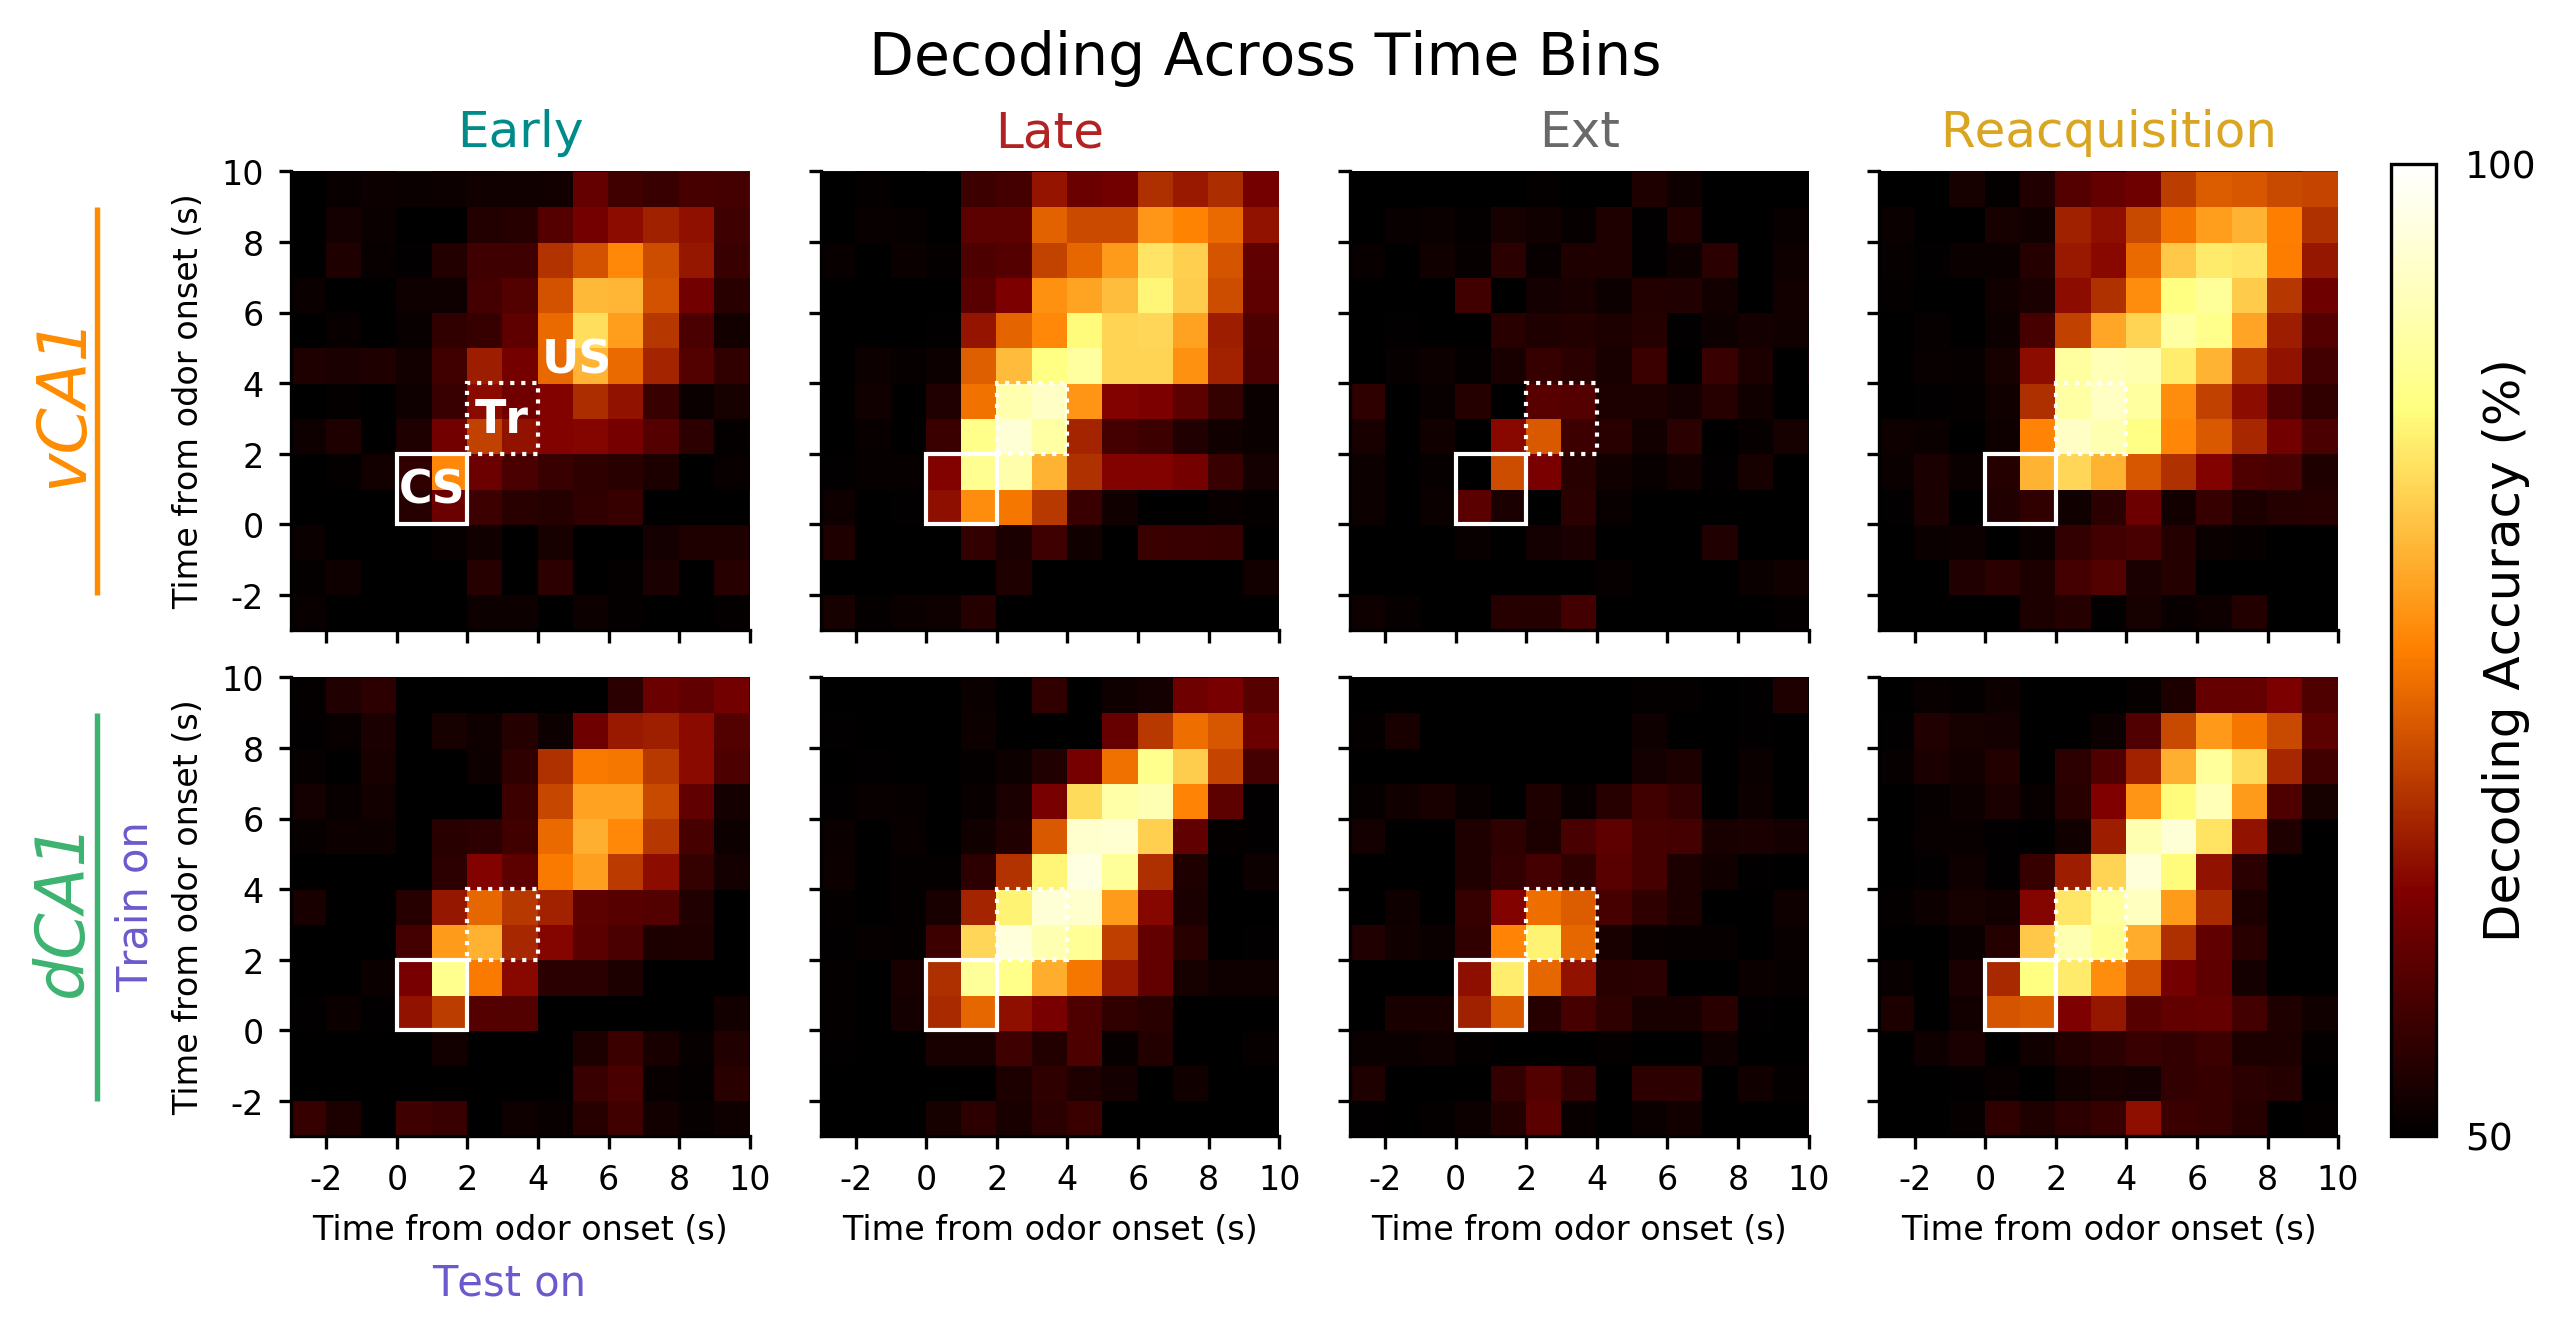

In [128]:
fig, ax = pl.subplots(2, 4, figsize=(7.5, 4), sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(['pre','post','ext2','renew'],range(4)):
    for reg, y in zip (['vhpc','dhpc'],range(2)):
        im = ax[y][x].pcolormesh(eval("distinct_%s[sess]"%reg),vmin=vmin, vmax=vmax,cmap='afmhot')
        #ax[y][x].axis('image')
for x,lab in zip(range(4),[1,3,5,6]):
    for y in range (2):
        ax[y][x].set_xticks(range(1,16,2))
        ax[y][x].set_yticks(range(1,16,2))
        ax[y][x].set_ylim(2, 15)
        ax[y][x].set_xlim(2, 15)
        ax[y][x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=8)
        ax[y][x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=8)
        ax[y][0].set_ylabel('Time from odor onset (s)', fontsize=8)
        ax[1][x].set_xlabel('Time from odor onset (s)', fontsize=8)
        ax[0][x].set_title(session_labels[lab],fontsize=12,color=dark_co[lab])
        ax[y][x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(4):
    for y in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[y][x].add_patch(CS)
        ax[y][x].add_patch(Tr)

ax[0][0].text(4.75+.3,5.1+.5,"CS",fontsize=11, weight='bold', color='w')
ax[0][0].text(6.85+.35,7.1+.5,"Tr",fontsize=11, weight='bold', color='w')
ax[0][0].text(8.6+.5,8.8+.5,"US",fontsize=11, weight='bold', color='w')
ax[1][0].text(6,-2.5,"Test on", fontsize=10,color='slateblue')
ax[1][0].text(-3,10,"Train on", fontsize=10, rotation=90,color='slateblue')
ax[0][0].text(-5.4,9.5,"vCA1", fontsize=16, rotation=90,color='darkorange',style='italic')
ax[1][0].text(-5.4,9.5,"dCA1", fontsize=16, rotation=90,color='mediumseagreen',style='italic')
ax[0][0].vlines(-3.5,3,14,color='darkorange',lw=1.3,clip_on=False)
ax[1][0].vlines(-3.5,3,14,color='mediumseagreen',lw=1.3,clip_on=False)
pl.suptitle('Decoding Across Time Bins',y=1.04,fontsize=14)

cax = fig.add_axes([1,0.118, 0.02, 0.81])
cbar=fig.colorbar(im, cax=cax,ticks=[.5,1])
cbar.ax.set_yticklabels(['50','100'])
cbar.set_label('Decoding Accuracy (%)',size=12,labelpad=-13)
cbar.ax.tick_params(labelsize=9,right=False)
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dv_PrPoExRe.pdf'%NOTEBOOK_NAME)

In [51]:
distinct_vhpc['renew']

([0.50858333333333339,
  0.53033333333333332,
  0.4975,
  0.50483333333333336,
  0.51483333333333337,
  0.49983333333333335,
  0.51983333333333337,
  0.47716666666666679,
  0.43116666666666653,
  0.47983333333333339,
  0.5099999999999999,
  0.52983333333333338,
  0.49916666666666659,
  0.48149999999999998,
  0.50683333333333336,
  0.49500000000000011],
 [0.53616666666666668,
  0.52733333333333332,
  0.51550000000000007,
  0.52016666666666667,
  0.50266666666666682,
  0.503,
  0.48066666666666674,
  0.47233333333333327,
  0.51783333333333337,
  0.4863333333333334,
  0.4951666666666667,
  0.48116666666666658,
  0.52549999999999997,
  0.48400000000000004,
  0.46466666666666673,
  0.50866666666666671],
 [0.4973333333333334,
  0.53666666666666674,
  0.48216666666666669,
  0.48749999999999999,
  0.4933333333333334,
  0.49350000000000005,
  0.52766666666666673,
  0.53516666666666668,
  0.50216666666666665,
  0.52249999999999996,
  0.50933333333333353,
  0.51516666666666677,
  0.53483333333333

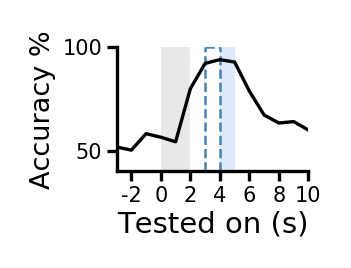

In [113]:
fig, ax = pl.subplots(1,1,figsize=(1.25, .94))

for sess,co,la,sty in zip(['renew'],[dark_co[-1]],['Reacq'],['-','-','-']):
    ax.plot([(t-4) for t in range(16)], [(distinct_vhpc['renew'][t][8]*100) for t in range(16)],
            color='k',label=la,linestyle=sty,lw=.8)
    #m = np.array([(distinct_vhpc['renew'][10][t]*100) for t in range(16)])
    #s = np.array([np.std(distinct_vhpc['renew'][10][t])*100 for t in range(16)])
    #ax.fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.17,color=co,linewidth=0)
#for t in range(1,16):
#    add_significance_line(ax, eval("mean_scores_gmin_tb_%s_dhpc['pre'][:10]"%t), eval("mean_scores_gmin_tb_%s_dhpc['post'][:10]"%t),
#                         t-4.5, t-3.5, 100,color1=dark_co[1],color2=dark_co[2],thresh=.01,lines=True,stars=True,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
#    #add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
ax.set_ylim(40, 100)
ax.set_xlim(-3, 10)
ax.tick_params(axis='both',pad=1,length=2.5)
ax.set_xticks(np.arange(-2,11, 2))
ax.set_xticklabels(np.arange(-2,11, 2))
ax.hlines(100, 3,4, color='steelblue', lw=.6, linestyles='dashed')
ax.vlines(3, 40,100, color='steelblue', lw=.6, linestyles='dashed')
ax.vlines(4, 40,100, color='steelblue', lw=.6, linestyles='dashed')
ax.set_xlabel('Tested on (s)',labelpad=1,fontsize=7)
ax.set_ylabel('Accuracy %',fontsize=6.5,labelpad=1.5)
pt.plot_period_bar(ax, 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
pt.plot_period_bar(ax, 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
#ax.text(-2.7,90,'Reacq',color=dark_co[-1],fontsize=7)
#ax.set_title('vCA1', color='#FC766AFF',fontstyle='italic',fontsize=8)
#ax.set_title('Trained on: 3-4s\npost odor onset',fontsize=6.5)
fig.tight_layout(pad=2)


fig.savefig('../final-ish figures/%s_xtbins_ex1.pdf'%NOTEBOOK_NAME)

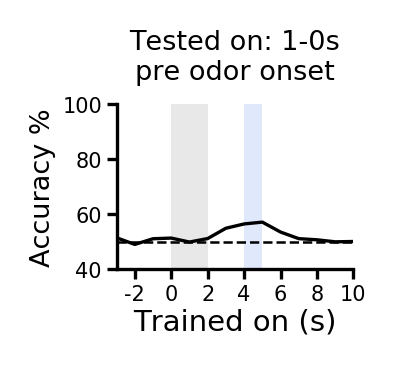

In [96]:
fig, ax = pl.subplots(1,1,figsize=(1.4, 1.3))

for sess,co,la,sty in zip(['renew'],[dark_co[-1]],['Reacq'],['-','-','-']):
    ax.plot([(t-4) for t in range(16)], [(distinct_vhpc['renew'][4][t]*100) for t in range(16)],
            color='k',label=la,linestyle=sty,lw=.8)
    #m = np.array([(distinct_vhpc['renew'][10][t]*100) for t in range(16)])
    #s = np.array([np.std(distinct_vhpc['renew'][10][t])*100 for t in range(16)])
    #ax.fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.17,color=co,linewidth=0)
#for t in range(1,16):
#    add_significance_line(ax, eval("mean_scores_gmin_tb_%s_dhpc['pre'][:10]"%t), eval("mean_scores_gmin_tb_%s_dhpc['post'][:10]"%t),
#                         t-4.5, t-3.5, 100,color1=dark_co[1],color2=dark_co[2],thresh=.01,lines=True,stars=True,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
#    #add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
ax.set_ylim(40, 100)
ax.set_xlim(-3, 10)
ax.tick_params(axis='both',pad=1,length=2.5)
ax.set_xticks(np.arange(-2,11, 2))
ax.set_xticklabels(np.arange(-2,11, 2))
ax.hlines(50, -3,11, color='k', lw=.6, linestyles='dashed')
ax.set_xlabel('Trained on (s)',labelpad=1,fontsize=7)
ax.set_ylabel('Accuracy %',fontsize=6.5,labelpad=1.5)
pt.plot_period_bar(ax, 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
pt.plot_period_bar(ax, 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
#ax.text(-2.7,90,'Reacq',color=dark_co[-1],fontsize=7)
#ax.set_title('vCA1', color='#FC766AFF',fontstyle='italic',fontsize=8)
ax.set_title('Tested on: 1-0s\npre odor onset',fontsize=6.5)
#ax.legend(loc=(.02,.66),frameon=False)
fig.tight_layout(pad=2)


fig.savefig('../final-ish figures/%s_xtbins_ex2.pdf'%NOTEBOOK_NAME)

In [13]:
for r in 'dhpc','vhpc':
    for x in range(8):
        exec("diagonal_offset_plus%s_%s = {}"%(x,r))
        exec("diagonal_offset_minus%s_%s = {}"%(x,r))
        for sess in sessions:
            exec("diagonal_offset_plus%s_%s[sess] = []"%(x,r))
            exec("diagonal_offset_minus%s_%s[sess] = []"%(x,r))
            for y in range(7,14):
                if x+y < 16:
                    exec("diagonal_offset_plus%s_%s[sess].append(distinct_%s[sess][y][y+x])"%(x,r,r))
                    exec("diagonal_offset_minus%s_%s[sess].append(distinct_%s[sess][y][y-x])"%(x,r,r))

In [14]:
import matplotlib.lines
from matplotlib.lines import Line2D
def add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    if lines==True:
        if p < thresh/mcc:
            if np.mean(array1) > np.mean(array2):
                line = Line2D([x1, x2], [y,y], lw=1, color=color1, clip_on=False)
            if np.mean(array1) < np.mean(array2):
                line = Line2D([x1, x2], [y,y], lw=1, color=color2, clip_on=False)
            ax.add_line(line)
    if stars == True:
        ax.text(np.mean([x1, x2]), y+1,
            '' if p > thresholds[0]/mcc else
            '' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [15]:
sstats.mannwhitneyu(diagonal_offset_plus6_dhpc['renew'],diagonal_offset_plus6_vhpc['renew'], alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.08085559837005224)

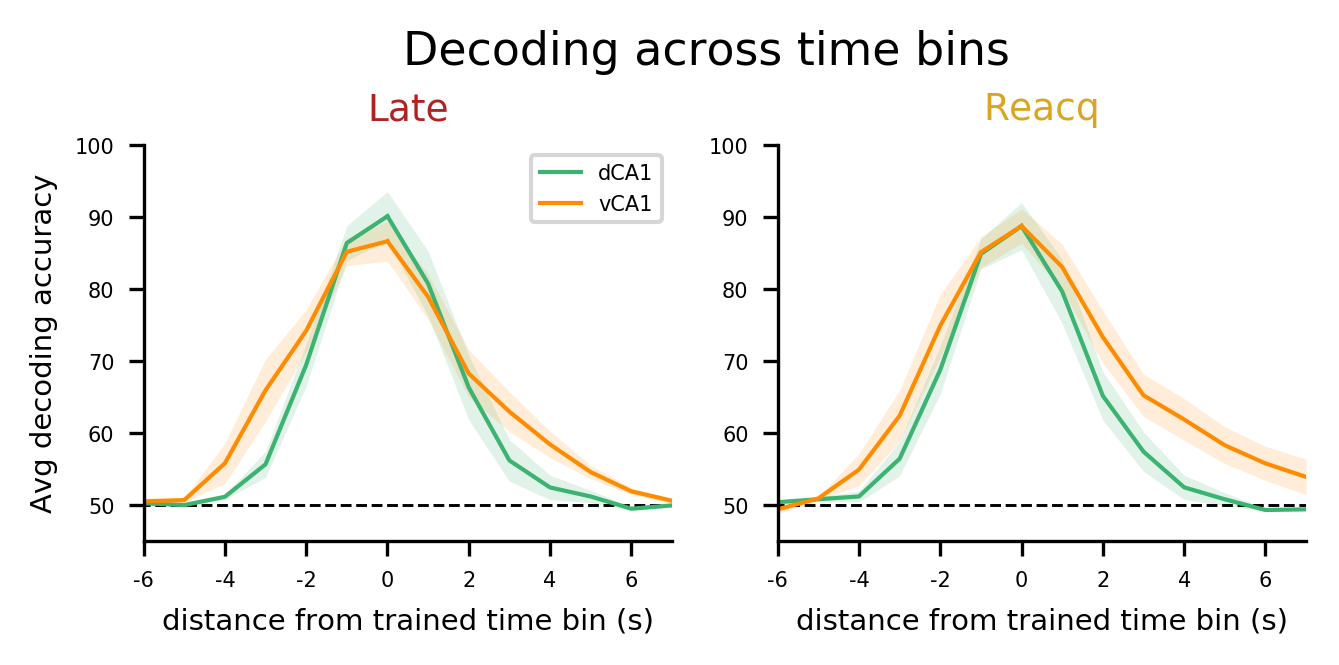

In [16]:
fig, ax = pl.subplots(1,2,figsize=(5,1.75))
for c,sess in zip ([0,1],['post','renew']):
    x=range(8)
    d=[]
    ds=[]
    v=[]
    vs=[]
    for i in range (7,-1,-1):
        d.append(np.mean(eval("diagonal_offset_minus%s_dhpc[sess]"%(i)))*100)
        ds.append((np.std(eval("diagonal_offset_minus%s_dhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_minus%s_dhpc[sess]"%(i)))))*100)
        v.append(np.mean(eval("diagonal_offset_minus%s_vhpc[sess]"%(i)))*100)
        vs.append((np.std(eval("diagonal_offset_minus%s_vhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_minus%s_vhpc[sess]"%(i)))))*100)
    d=np.array(d)
    ds=np.array(ds)
    v=np.array(v)
    vs=np.array(vs)
    ax[c].plot(x,d,color='mediumseagreen',linewidth=1)
    ax[c].fill_between(x,d-ds,d+ds,alpha=.15,color='mediumseagreen',linewidth=0.0)
    ax[c].plot(x,v,color='darkorange',linewidth=1)
    ax[c].fill_between(x,v-vs,v+vs,alpha=.15,color='darkorange',linewidth=0.0)
    for i,t in zip(range(7,-1,-1),[0,1,2,3,4,5,6,7]):
        add_significance_line(ax[c],eval("diagonal_offset_minus%s_dhpc[sess]"%(i)),eval("diagonal_offset_minus%s_vhpc[sess]"%(i)),
                         t, t+1, 100,color1='mediumseagreen',color2='darkorange',thresh=.01,lines=True,stars=True,sig_func=None,
                              thresholds=(0.05, 0.01, 0.001),mcc=1)
    
    x = range(7,15)
    d=[]
    ds=[]
    v=[]
    vs=[]
    for i in range (8):
        d.append(np.mean(eval("diagonal_offset_plus%s_dhpc[sess]"%(i)))*100)
        ds.append((np.std(eval("diagonal_offset_plus%s_dhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_plus%s_dhpc[sess]"%(i)))))*100)
        v.append(np.mean(eval("diagonal_offset_plus%s_vhpc[sess]"%(i)))*100)
        vs.append((np.std(eval("diagonal_offset_plus%s_vhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_plus%s_vhpc[sess]"%(i)))))*100)
    d=np.array(d)
    ds=np.array(ds)
    v=np.array(v)
    vs=np.array(vs)
    ax[c].plot(x,d,color='mediumseagreen',linewidth=1,label='dCA1')
    ax[c].fill_between(x,d-ds,d+ds,alpha=.15,color='mediumseagreen',linewidth=0.0)
    ax[c].plot(x,v,color='darkorange',linewidth=1,label='vCA1')
    ax[c].fill_between(x,v-vs,v+vs,alpha=.15,color='darkorange',linewidth=0.0)
    for i,t in zip(range(8),[0,1,2,3,4,5,6,7]):
        add_significance_line(ax[c],eval("diagonal_offset_plus%s_dhpc[sess]"%(i)),eval("diagonal_offset_plus%s_vhpc[sess]"%(i)),
                         t, t+1, 100,color1='mediumseagreen',color2='darkorange',thresh=.05,lines=True,stars=True,sig_func=None,
                              thresholds=(0.05, 0.01, 0.001),mcc=1)
    
    ax[c].set_ylim(45,100)
    ax[c].set_xlim(1,14)
    ax[0].set_title('Late',color=dark_co[3],fontsize=9)
    ax[1].set_title('Reacq',color=dark_co[-1],fontsize=9)
    ax[c].hlines(50,-1,15, color='k', lw=.7, linestyles='dashed')
    pl.suptitle('Decoding across time bins',y=1.1,fontsize=11)
    ax[c].set_xticks(range(1,15,2))
    ax[c].set_xlabel('distance from trained time bin (s)')
    ax[c].set_xticklabels(range(-6,8,2))
    ax[0].set_ylabel('Avg decoding accuracy')
    ax[0].legend()
fig.savefig('../final-ish figures/%s_avg_by_distance_from_trained_bin.pdf'%NOTEBOOK_NAME)

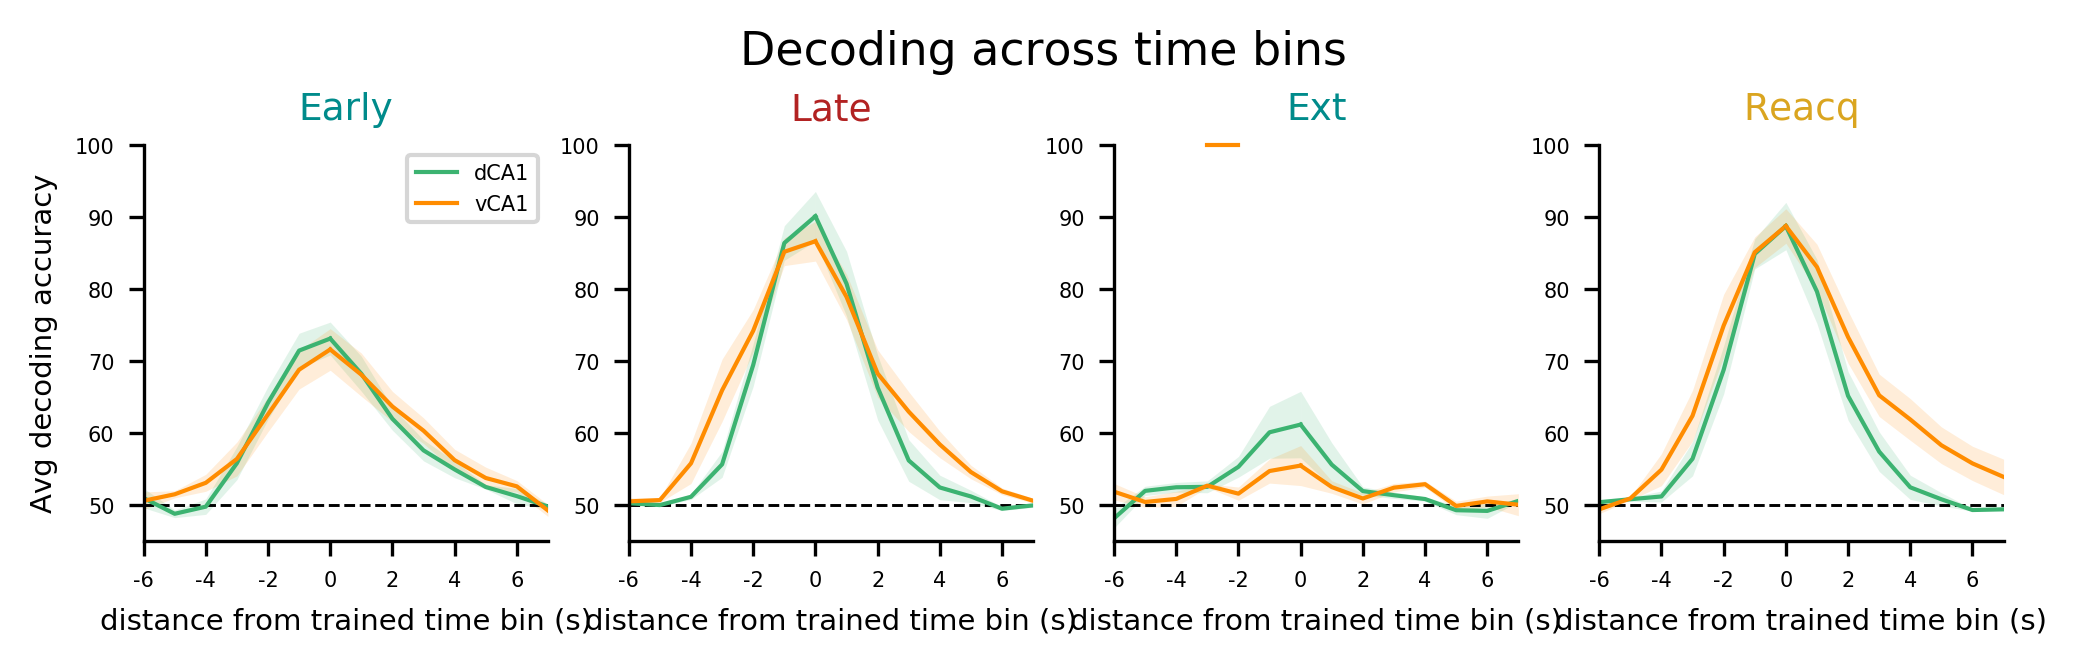

In [569]:
fig, ax = pl.subplots(1,4,figsize=(8,1.75))
for c,sess in zip ([0,1,2,3],['pre', 'post','ext2','renew']):
    x=range(8)
    d=[]
    ds=[]
    v=[]
    vs=[]
    for i in range (7,-1,-1):
        d.append(np.mean(eval("diagonal_offset_minus%s_dhpc[sess]"%(i)))*100)
        ds.append((np.std(eval("diagonal_offset_minus%s_dhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_minus%s_dhpc[sess]"%(i)))))*100)
        v.append(np.mean(eval("diagonal_offset_minus%s_vhpc[sess]"%(i)))*100)
        vs.append((np.std(eval("diagonal_offset_minus%s_vhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_minus%s_vhpc[sess]"%(i)))))*100)
    d=np.array(d)
    ds=np.array(ds)
    v=np.array(v)
    vs=np.array(vs)
    ax[c].plot(x,d,color='mediumseagreen',linewidth=1)
    ax[c].fill_between(x,d-ds,d+ds,alpha=.15,color='mediumseagreen',linewidth=0.0)
    ax[c].plot(x,v,color='darkorange',linewidth=1)
    ax[c].fill_between(x,v-vs,v+vs,alpha=.15,color='darkorange',linewidth=0.0)
    for i,t in zip(range(7,-1,-1),[0,1,2,3,4,5,6,7]):
        add_significance_line(ax[c],eval("diagonal_offset_minus%s_dhpc[sess]"%(i)),eval("diagonal_offset_minus%s_vhpc[sess]"%(i)),
                         t, t+1, 100,color1='mediumseagreen',color2='darkorange',thresh=.01,lines=True,stars=True,sig_func=None,
                              thresholds=(0.05, 0.01, 0.001),mcc=1)
    
    x = range(7,15)
    d=[]
    ds=[]
    v=[]
    vs=[]
    for i in range (8):
        d.append(np.mean(eval("diagonal_offset_plus%s_dhpc[sess]"%(i)))*100)
        ds.append((np.std(eval("diagonal_offset_plus%s_dhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_plus%s_dhpc[sess]"%(i)))))*100)
        v.append(np.mean(eval("diagonal_offset_plus%s_vhpc[sess]"%(i)))*100)
        vs.append((np.std(eval("diagonal_offset_plus%s_vhpc[sess]"%(i))))/(np.sqrt(len(eval("diagonal_offset_plus%s_vhpc[sess]"%(i)))))*100)
    d=np.array(d)
    ds=np.array(ds)
    v=np.array(v)
    vs=np.array(vs)
    ax[c].plot(x,d,color='mediumseagreen',linewidth=1,label='dCA1')
    ax[c].fill_between(x,d-ds,d+ds,alpha=.15,color='mediumseagreen',linewidth=0.0)
    ax[c].plot(x,v,color='darkorange',linewidth=1,label='vCA1')
    ax[c].fill_between(x,v-vs,v+vs,alpha=.15,color='darkorange',linewidth=0.0)
    for i,t in zip(range(8),[0,1,2,3,4,5,6,7]):
        add_significance_line(ax[c],eval("diagonal_offset_plus%s_dhpc[sess]"%(i)),eval("diagonal_offset_plus%s_vhpc[sess]"%(i)),
                         t, t+1, 100,color1='mediumseagreen',color2='darkorange',thresh=.05,lines=True,stars=True,sig_func=None,
                              thresholds=(0.05, 0.01, 0.001),mcc=1)
    
    ax[c].set_ylim(45,100)
    ax[c].set_xlim(1,14)
    ax[0].set_title('Early',color=dark_co[1],fontsize=9)
    ax[1].set_title('Late',color=dark_co[3],fontsize=9)
    ax[2].set_title('Ext',color=dark_co[1],fontsize=9)
    ax[3].set_title('Reacq',color=dark_co[-1],fontsize=9)
    ax[c].hlines(50,-1,15, color='k', lw=.7, linestyles='dashed')
    pl.suptitle('Decoding across time bins',y=1.1,fontsize=11)
    ax[c].set_xticks(range(1,15,2))
    ax[c].set_xlabel('distance from trained time bin (s)')
    ax[c].set_xticklabels(range(-6,8,2))
    ax[0].set_ylabel('Avg decoding accuracy')
    ax[0].legend()
#fig.savefig('../final-ish figures/%s_avg_by_distance_from_trained_bin.pdf'%NOTEBOOK_NAME)

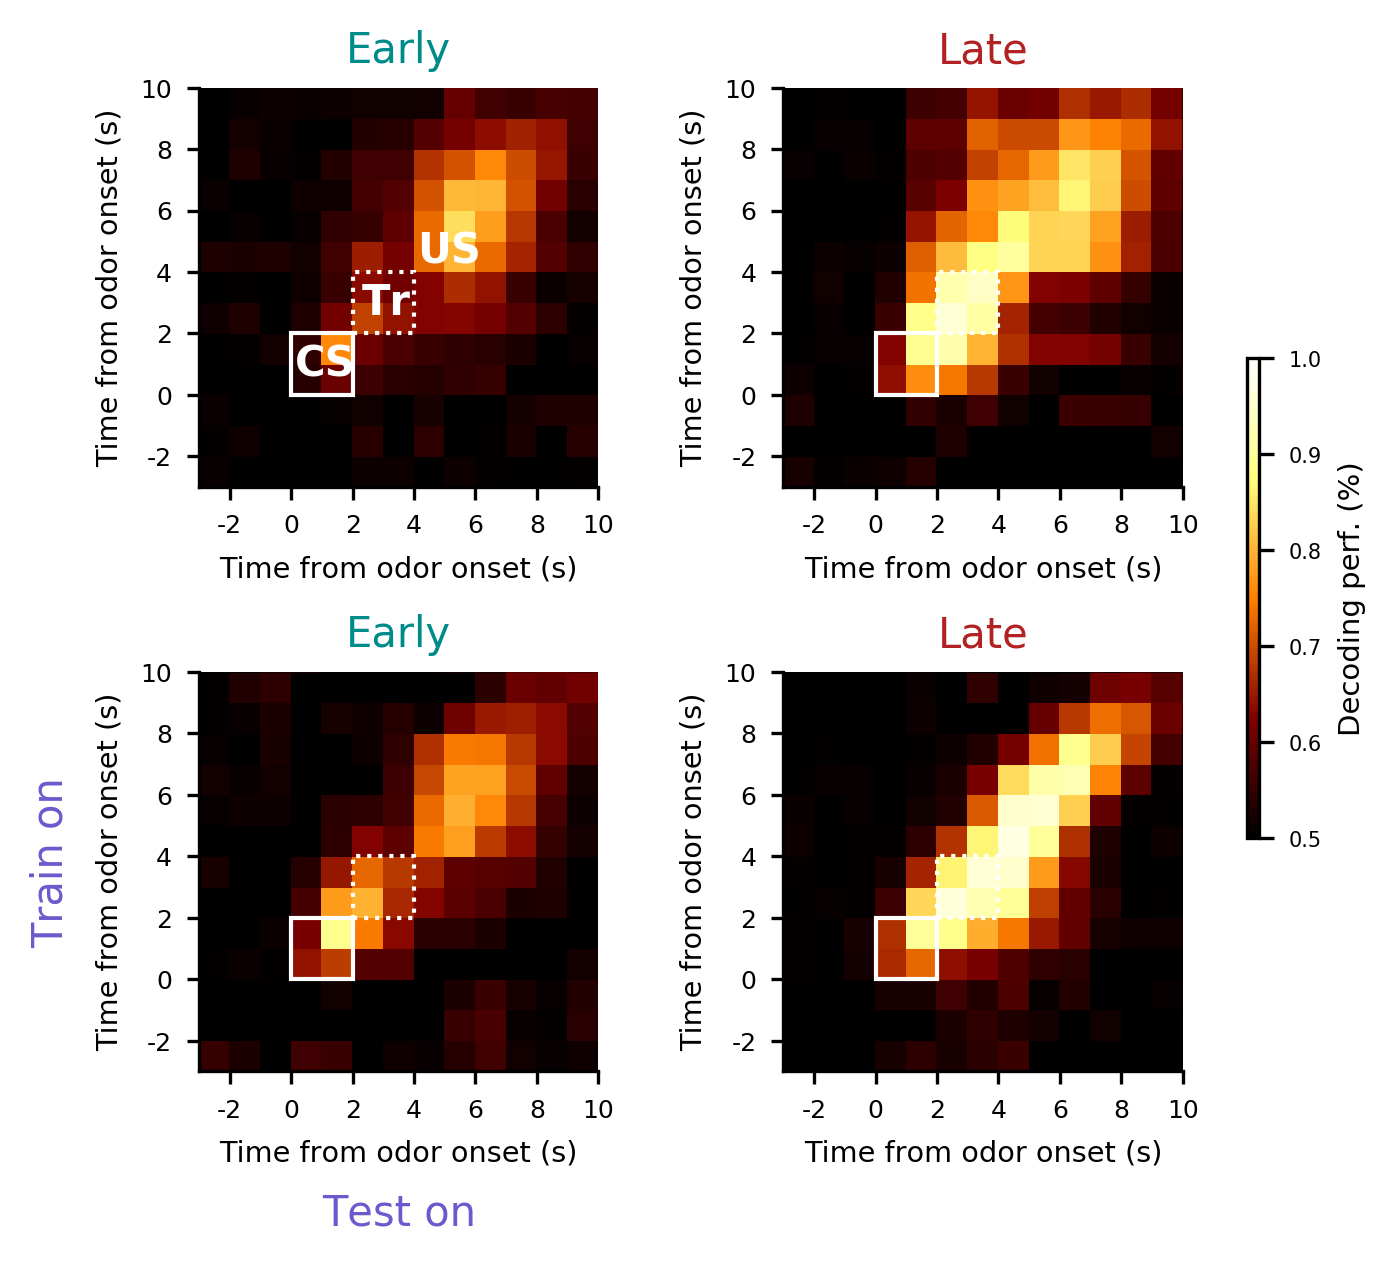

In [37]:
fig, ax = pl.subplots(2, 2, figsize=(4, 4))#, sharex=True, sharey=True)vmin=0.5
vmin=0.5
vmax=1
for sess,x in zip(['pre','post'],range(2)):
    for reg, y in zip (['vhpc','dhpc'],range(2)):
        im = ax[y][x].pcolormesh(eval("distinct_%s[sess]"%reg),vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[y][x].axis('image')
for sess,x in zip([1,3],range(2)):
    for y in range (2):
        ax[y][x].set_xticks(range(1,16,2))
        ax[y][x].set_yticks(range(1,16,2))
        ax[y][x].set_ylim(2, 15)
        ax[y][x].set_xlim(2, 15)
        ax[y][x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
        ax[y][x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
        ax[y][x].set_title(session_labels[sess],fontsize=10,color=dark_co[sess])
        ax[y][x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(2):
    for y in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[y][x].add_patch(CS)
        ax[y][x].add_patch(Tr)

ax[0][0].text(5.12,5.6,"CS",fontsize=10, weight='bold', color='w')
ax[0][0].text(7.3,7.1+.5,"Tr",fontsize=10, weight='bold', color='w')
ax[0][0].text(8.6+.5,8.8+.5,"US",fontsize=10, weight='bold', color='w')
ax[1][0].text(6,-3,"Test on", fontsize=10,color='slateblue')
ax[1][0].text(-3.5,10.5,"Train on", fontsize=10, rotation=90,color='slateblue')

#pl.suptitle('vCA1 (upper) and dCA1 (lwr) Decoding Performance',y=1,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dv.pdf'%NOTEBOOK_NAME)

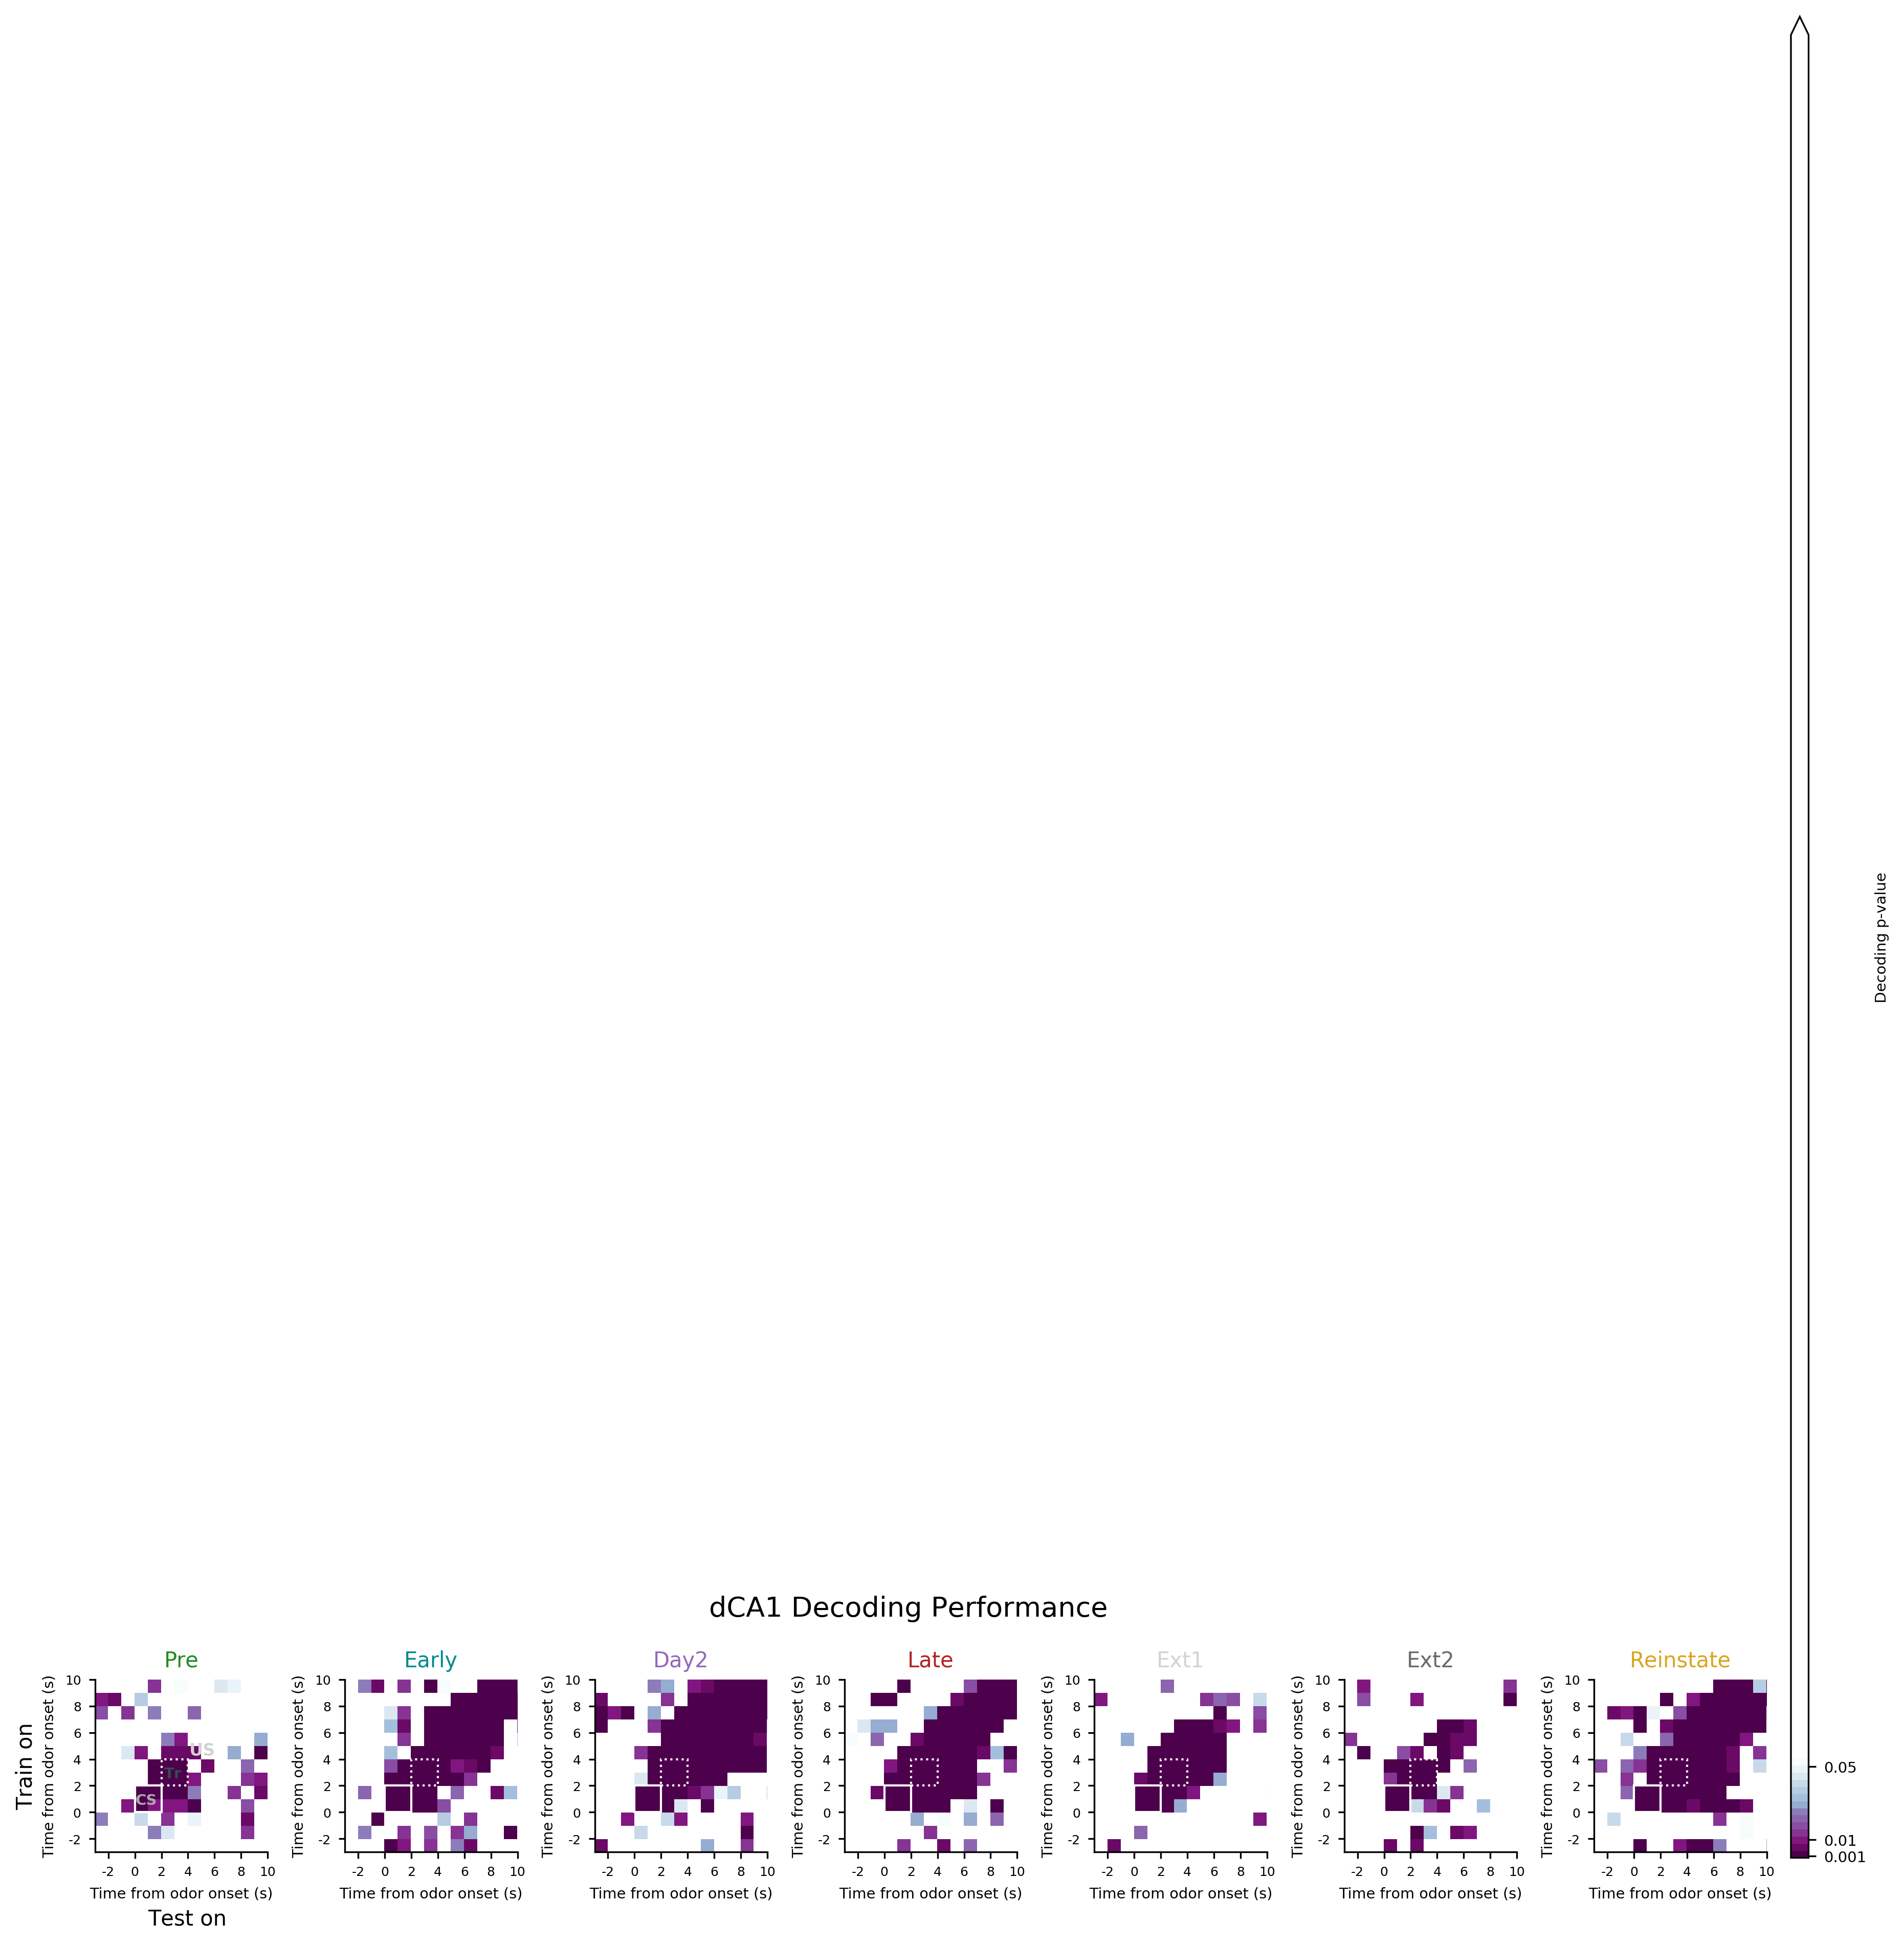

In [53]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 14)),
                       sigs(np.linspace(0, 1, 242))))
#pink = np.array([.96, .09, .6, 1])
newcolors[14:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_wilcox_dhpc[sess],vmin=vmin, vmax=vmax,cmap=newcmap)
    ax[x].axis('image')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 4])
cbar = fig.colorbar(im, cax=cax, label='Decoding p-value',ticks=[.001,.01,.05],extend='max',extendfrac=.01)
cbar.ax.set_yticklabels(['0.001','0.01','0.05'],fontsize=7)
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dCA1_wilcoxon.pdf'%NOTEBOOK_NAME)

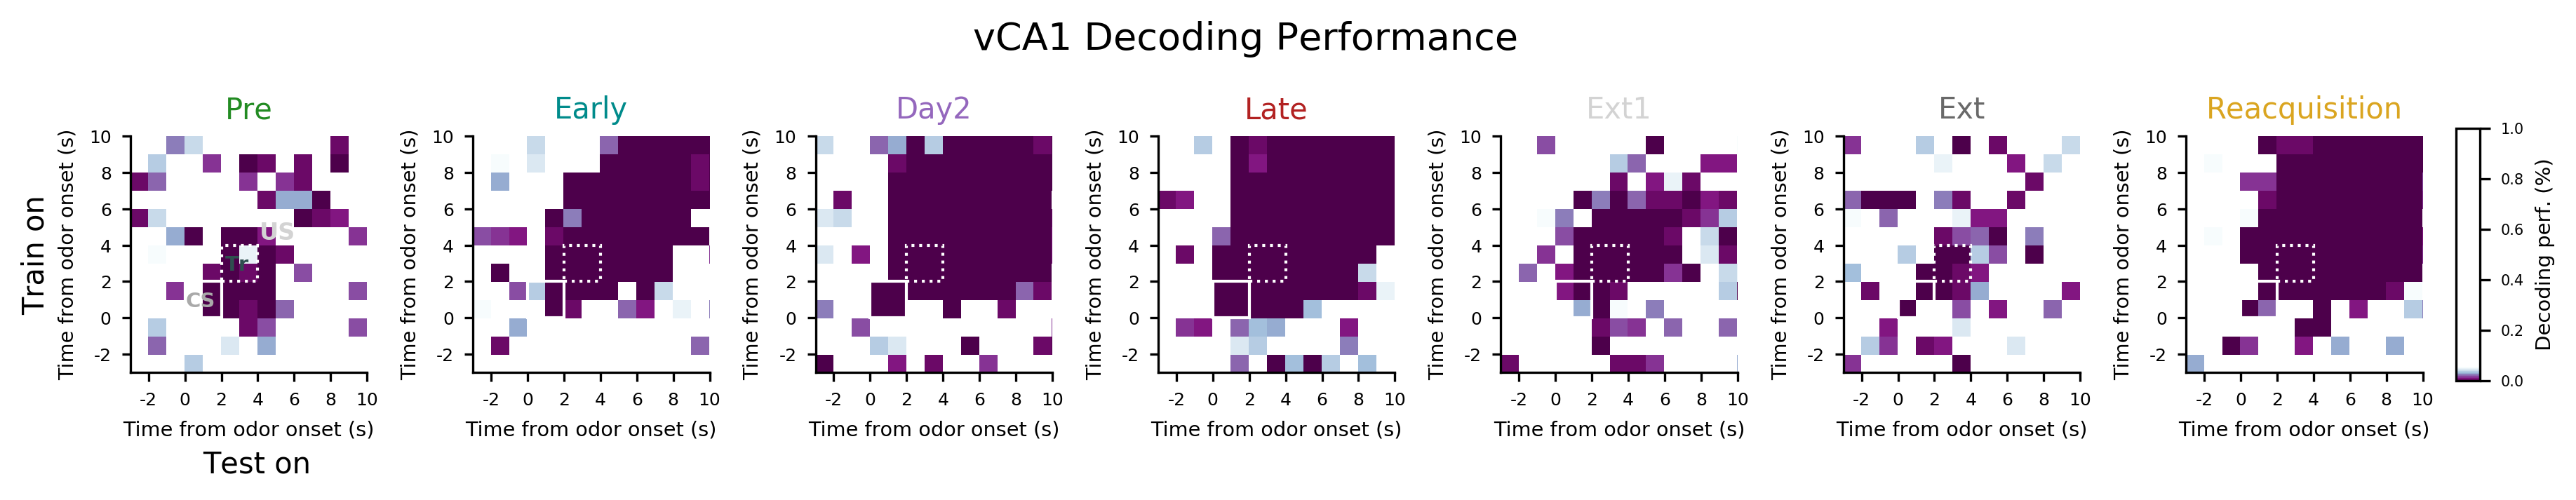

In [570]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 14)),
                       sigs(np.linspace(0, 1, 242))))
#pink = np.array([.96, .09, .6, 1])
newcolors[14:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_wilcox_vhpc[sess],vmin=vmin, vmax=vmax,cmap=newcmap)
    ax[x].axis('image')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_vCA1_wilcoxon.pdf'%NOTEBOOK_NAME)

## now compare vhpc vs dhpc decoding

In [30]:
for r in 'dhpc','vhpc':
    for t in range (16):
        for c in range (16):
            exec('scores_gmin_tb_distinct_%s_VS_%s_%s = {}'%(t,c,r))
            for sess in sessions:
                if r == 'dhpc':
                    exec("scores_gmin_tb_distinct_%s_VS_%s_%s = ut.load_variable('scores_gmin_tb_distinct_%s_VS_%s',\
                     '../notebooks/autorestore/decoding_around_onset_combined_%s/')"%(t,c,r,t,c,r))
                if r == 'vhpc':
                    exec("scores_gmin_tb_distinct_%s_VS_%s_%s = ut.load_variable('scores_gmin_tb_distinct_%s_VS_%s',\
                     '../notebooks/autorestore/decoding_around_onset_combined_%s_wBs/')"%(t,c,r,t,c,r))

In [31]:
loops=15
for t in range (16):
    exec('distinct%s_MannWhitney_dhpcVSvhpc = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_MannWhitney_dhpcVSvhpc['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct%s_MannWhitney_dhpcVSvhpc'%t)[sess].insert(c,
                  sstats.mannwhitneyu(eval('scores_gmin_tb_distinct_%s_VS_%s_dhpc[sess][:,0][:loops]'%(t,c)),
                  eval('scores_gmin_tb_distinct_%s_VS_%s_vhpc[sess][:,0][:loops]'%(t,c)), alternative='two-sided'))
        for x,i in zip(eval('distinct%s_MannWhitney_dhpcVSvhpc'%t)[sess],range(len(eval('distinct%s_MannWhitney_dhpcVSvhpc'%t)[sess]))):
            exec("distinct%s_MannWhitney_dhpcVSvhpc[sess][i] = x[-1]"%(t)) #only take p-values

In [32]:
distinct_MannWhitney_dhpcVSvhpc={}
for sess in sessions:
    distinct_MannWhitney_dhpcVSvhpc[sess]=(distinct0_MannWhitney_dhpcVSvhpc[sess], distinct1_MannWhitney_dhpcVSvhpc[sess], distinct2_MannWhitney_dhpcVSvhpc[sess], distinct3_MannWhitney_dhpcVSvhpc[sess],
                          distinct4_MannWhitney_dhpcVSvhpc[sess], distinct5_MannWhitney_dhpcVSvhpc[sess], distinct6_MannWhitney_dhpcVSvhpc[sess], distinct7_MannWhitney_dhpcVSvhpc[sess],
                          distinct8_MannWhitney_dhpcVSvhpc[sess], distinct9_MannWhitney_dhpcVSvhpc[sess], distinct10_MannWhitney_dhpcVSvhpc[sess], distinct11_MannWhitney_dhpcVSvhpc[sess],
                          distinct12_MannWhitney_dhpcVSvhpc[sess], distinct13_MannWhitney_dhpcVSvhpc[sess], distinct14_MannWhitney_dhpcVSvhpc[sess], distinct15_MannWhitney_dhpcVSvhpc[sess])
    np.array([distinct_MannWhitney_dhpcVSvhpc[sess]])

### code so we can visualize which region had better decoding for each significant bin

In [33]:
import copy
distinct_MannWhitney_dhpcVSvhpc_to_plot = copy.deepcopy(distinct_MannWhitney_dhpcVSvhpc)

In [34]:
##code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
#for sess in sessions:
#    for i in range(len(distinct_vhpc[sess])):
#        for j in range(len(distinct_vhpc[sess][i])):
#            distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0
#            if distinct_vhpc[sess][i][j] > distinct_dhpc[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
#                distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=-1
#            if distinct_vhpc[sess][i][j] < distinct_dhpc[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
#                distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=1
#            #else:
#            #    distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

In [35]:
#code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
import math
for sess in sessions:
    for i in range(len(distinct_vhpc[sess])):
        for j in range(len(distinct_vhpc[sess][i])):
            distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0
            if distinct_vhpc[sess][i][j] > distinct_dhpc[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]= (math.log10(distinct_MannWhitney_dhpcVSvhpc[sess][i][j]))
            if distinct_vhpc[sess][i][j] < distinct_dhpc[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]= -(math.log10(distinct_MannWhitney_dhpcVSvhpc[sess][i][j]))
            #else:
            #    distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

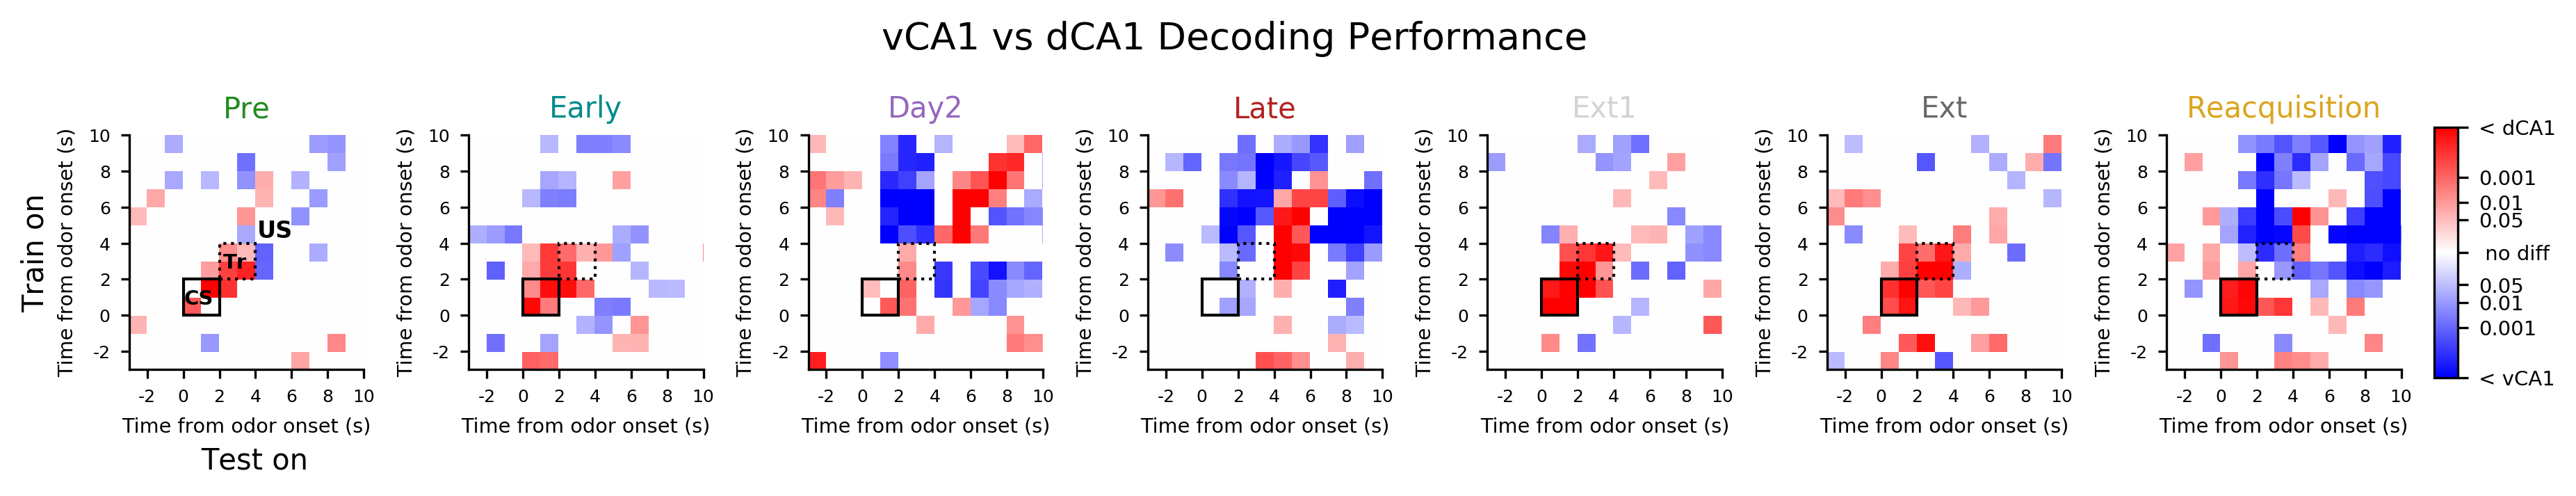

In [130]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=-5
vmax=5
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap='bwr')
    ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='k')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 vs dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-2,-1.3,0,1.3,2,3,5])
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.01','0.05', ' no diff', '0.05','0.01','0.001','< dCA1'],fontsize=7)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_dVSv_Utest.pdf'%NOTEBOOK_NAME)

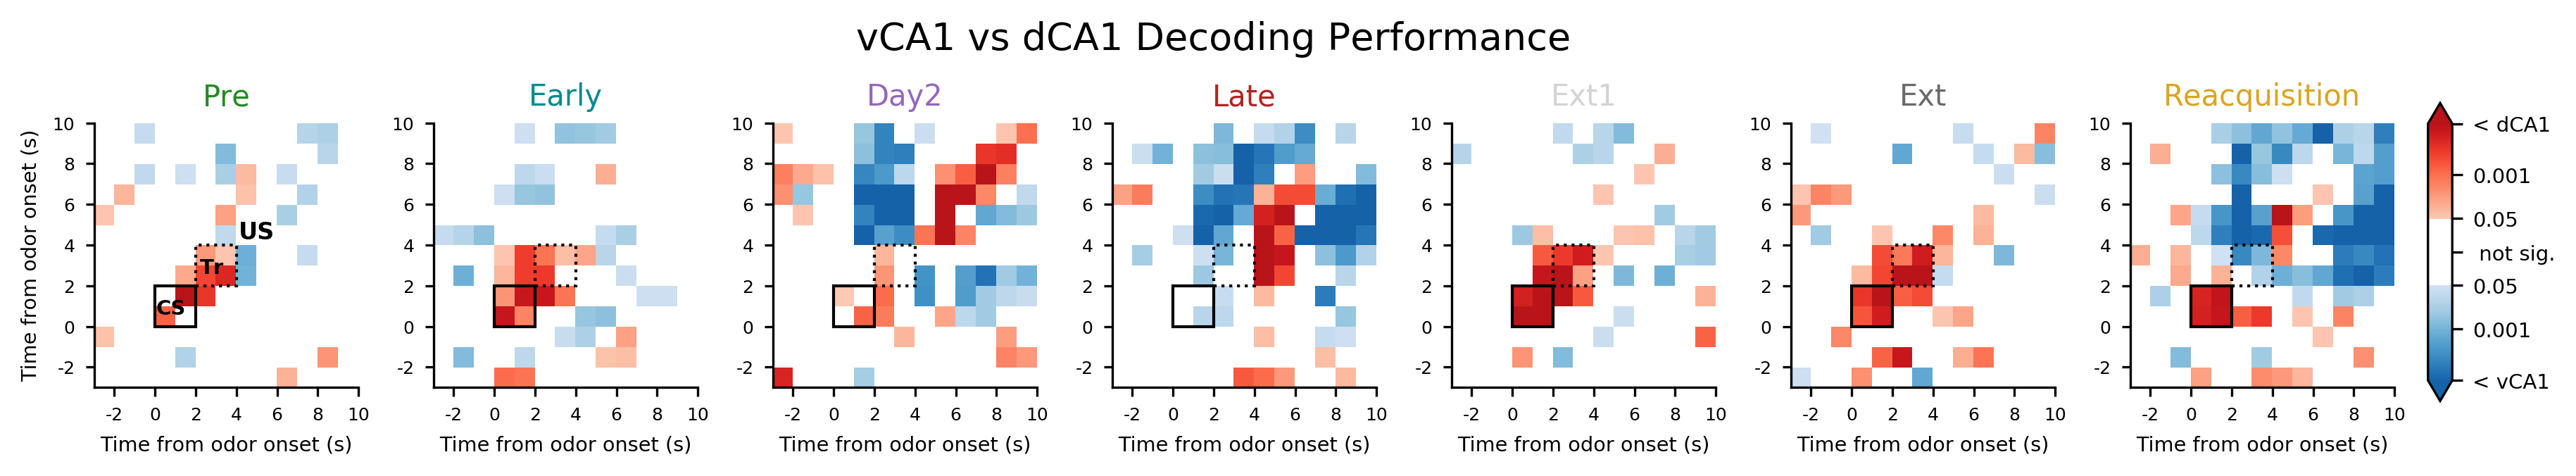

In [153]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
vsigs = cm.get_cmap('Blues', 80)
dsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=-5
vmax=5
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap=newcmap)
    ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[0].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='k')
#ax[0].text(6,-3.5,"Test on", fontsize=10)
#ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 vs dCA1 Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.27, 0.01, 0.47])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_across_bins_dVSv_Utest.pdf'%NOTEBOOK_NAME)

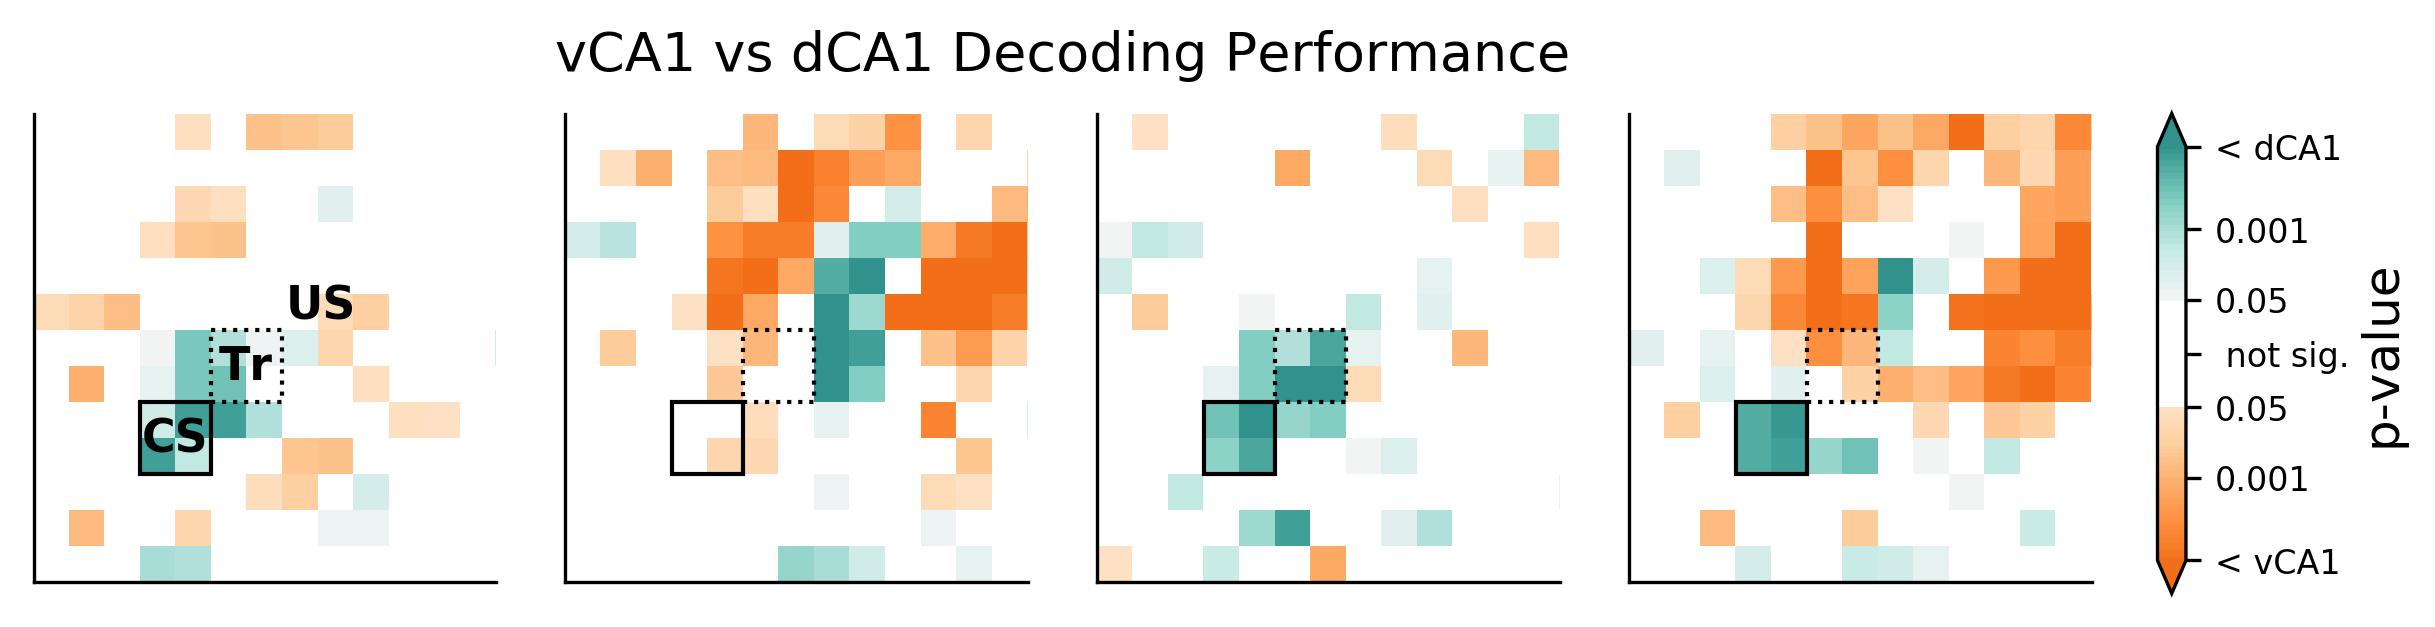

In [203]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
vsigs = cm.get_cmap('Oranges', 80)
dsigs = cm.get_cmap('BrBG', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.6, 0, 128)),
                       dsigs(np.linspace(.4, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 4, figsize=(7.3, 2), sharex=True, sharey=True)
vmin=-5
vmax=5
for sess,x in zip(['pre','post','ext2','renew'],range(4)):
    im = ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap=newcmap)
    #ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for x,lab in zip(range(4),[1,3,5,6]):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    #ax[0].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    #ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    #ax[x].set_title(session_labels[lab],fontsize=12,color=dark_co[lab])
    ax[x].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)

import matplotlib.patches as patches
for x in range(4):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=11, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=11, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=11, weight='bold', color='k')
#ax[0].text(6,-2.5,"Test on", fontsize=10,color='slateblue')
#ax[0].text(-3,10,"Train on", fontsize=10, rotation=90,color='slateblue')

pl.suptitle('vCA1 vs dCA1 Decoding Performance',y=1.03,fontsize=13)

cax = fig.add_axes([1,0.09, 0.013, 0.8])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=8)
cbar.set_label('p-value',size=12,labelpad=2)
fig.tight_layout(pad=3)
fig.savefig('../final-ish figures/%s_gmin_across_bins_dVSv_Utest_PrPoExRe.pdf'%NOTEBOOK_NAME)

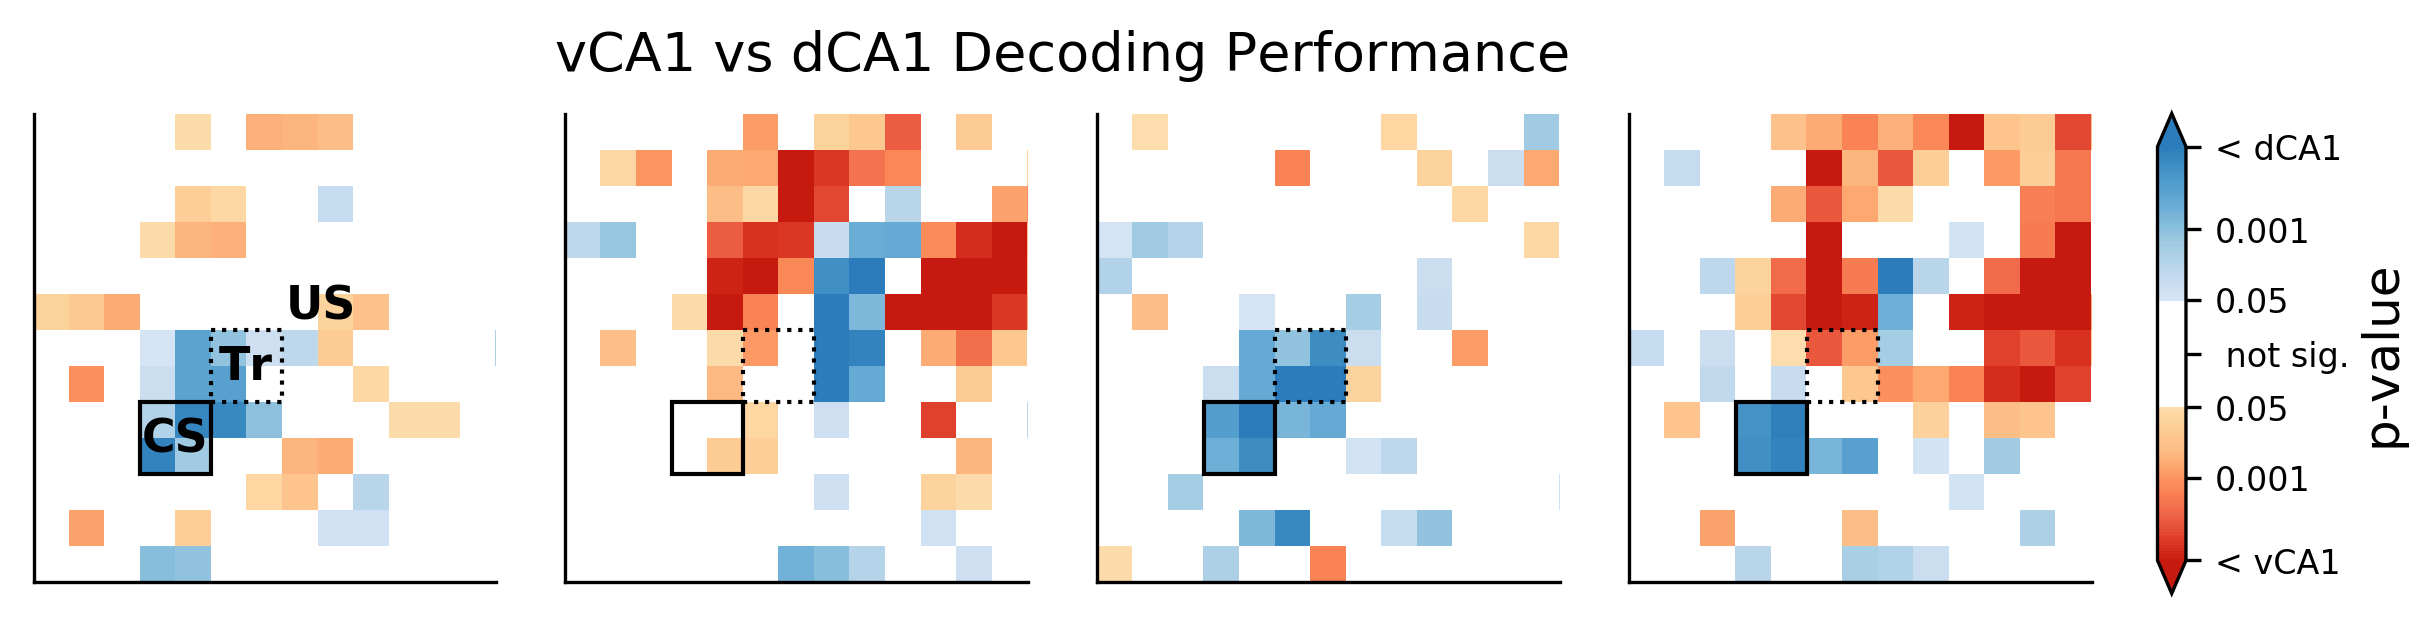

In [117]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
vsigs = cm.get_cmap('OrRd', 80)
dsigs = cm.get_cmap('Blues', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .7, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 4, figsize=(7.3, 2), sharex=True, sharey=True)
vmin=-5
vmax=5
for sess,x in zip(['pre','post','ext2','renew'],range(4)):
    im = ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap=newcmap)
    #ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for x,lab in zip(range(4),[1,3,5,6]):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    #ax[0].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    #ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    #ax[x].set_title(session_labels[lab],fontsize=12,color=dark_co[lab])
    ax[x].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)

import matplotlib.patches as patches
for x in range(4):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=11, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=11, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=11, weight='bold', color='k')
#ax[0].text(6,-2.5,"Test on", fontsize=10,color='slateblue')
#ax[0].text(-3,10,"Train on", fontsize=10, rotation=90,color='slateblue')

pl.suptitle('vCA1 vs dCA1 Decoding Performance',y=1.03,fontsize=13)

cax = fig.add_axes([1,0.09, 0.013, 0.8])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=8)
cbar.set_label('p-value',size=12,labelpad=2)
fig.tight_layout(pad=3)
fig.savefig('../final-ish figures/%s_gmin_across_bins_dVSv_Utest_PrPoExReb.pdf'%NOTEBOOK_NAME)

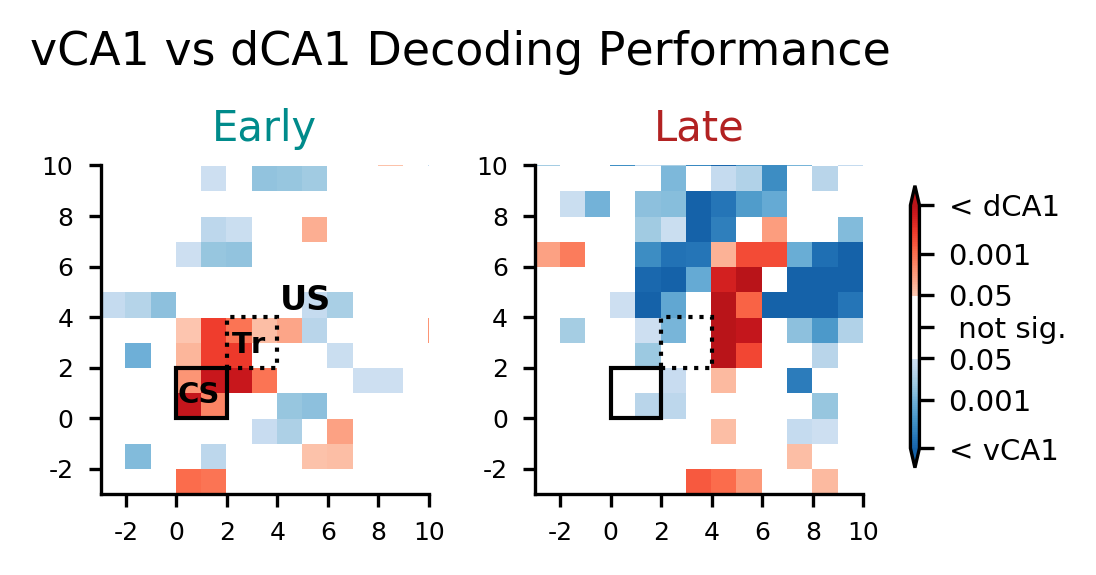

In [46]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
vsigs = cm.get_cmap('Blues', 80)
dsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 2, figsize=(3, 2))#, sharex=True, sharey=True)vmin=0.5
vmin=-5
vmax=5
for sess,x in zip(['pre','post'],range(2)):
    im = ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap=newcmap)
    ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for sess,x in zip([1,3],range(2)):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    #ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    #ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[sess],fontsize=10,color=dark_co[sess])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for sess,x in zip([1,3],range(2)):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='k')
#ax[0].text(6,-4.5,"Test on", fontsize=10,color='slateblue')
#ax[0].text(-5.2,10.5,"Train on", fontsize=10, rotation=90,color='slateblue')

pl.suptitle('vCA1 vs dCA1 Decoding Performance',y=1,fontsize=11)

cax = fig.add_axes([1,0.27, 0.01, 0.47])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)
fig.tight_layout(pad=1.5)
#fig.savefig('../final-ish figures/%s_gmin_across_bins_dVSv_Utest.pdf'%NOTEBOOK_NAME)

In [ ]:
fig, ax = pl.subplots(2, 2, figsize=(4, 4))#, sharex=True, sharey=True)vmin=0.5
vmin=0.5
vmax=1
for sess,x in zip(['pre','post'],range(2)):
    for reg, y in zip (['vhpc','dhpc'],range(2)):
        im = ax[y][x].pcolormesh(eval("distinct_%s[sess]"%reg),vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[y][x].axis('image')
for sess,x in zip([1,3],range(2)):
    for y in range (2):
        ax[y][x].set_xticks(range(1,16,2))
        ax[y][x].set_yticks(range(1,16,2))
        ax[y][x].set_ylim(2, 15)
        ax[y][x].set_xlim(2, 15)
        ax[y][x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[y][x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
        ax[y][x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
        ax[y][x].set_title(session_labels[sess],fontsize=10,color=dark_co[sess])
        ax[y][x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(2):
    for y in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[y][x].add_patch(CS)
        ax[y][x].add_patch(Tr)

ax[0][0].text(5.12,5.6,"CS",fontsize=10, weight='bold', color='w')
ax[0][0].text(7.3,7.1+.5,"Tr",fontsize=10, weight='bold', color='w')
ax[0][0].text(8.6+.5,8.8+.5,"US",fontsize=10, weight='bold', color='w')
ax[1][0].text(6,-3,"Test on", fontsize=10,color='slateblue')
ax[1][0].text(-3.5,10.5,"Train on", fontsize=10, rotation=90,color='slateblue')

#pl.suptitle('vCA1 (upper) and dCA1 (lwr) Decoding Performance',y=1,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../final-ish figures/%s_gmin_across_bins_distinct_dv.pdf'%NOTEBOOK_NAME)

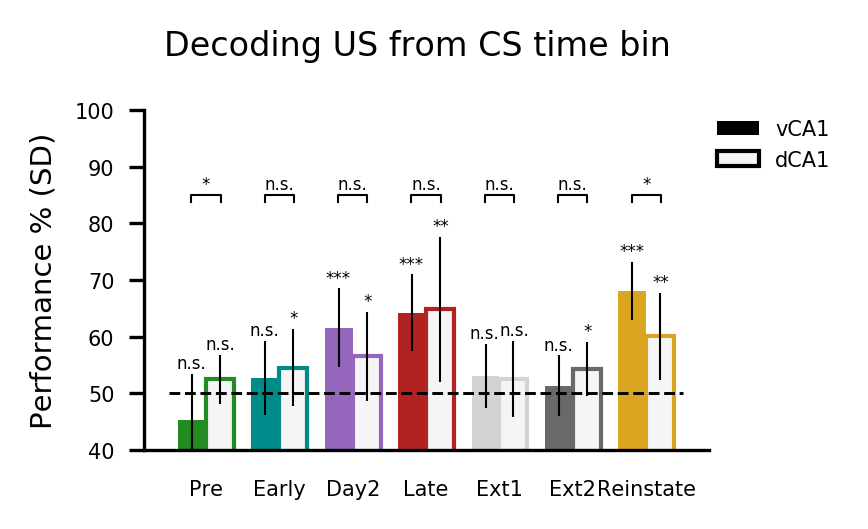

In [38]:
from matplotlib.patches import Patch
labels = session_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(sessions,dark_co,range(len(sessions))):
    v[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_vhpc[sess][:,0][:loops]*100))
    ax.bar(i - width/2, np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess][:loops].mean(0)[0])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_dhpc[sess][:,0][:loops]*100))
    ax.bar(i + width/2,  np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess][:loops].mean(0)[0])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,6.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
ax.set_ylim(40,100)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(sessions, range(len(sessions))):
    pvs.append(add_significance(ax, scores_gmin_tb_distinct_6_VS_10_vhpc[sess][:,0][:loops],
                                scores_gmin_tb_distinct_6_VS_10_dhpc[sess][:,0][:loops],-.2+i,0.2+i,85))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_vhpc[sess][:,0][:15],.5,-.2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess][:loops].mean(0)[0])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_dhpc[sess][:,0][:15],.5, .2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess][:loops].mean(0)[0])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding US from CS time bin',y=1.06,fontsize=8)

fig.savefig('../img/%s_decodingUSfromCS_allsess.pdf'%NOTEBOOK_NAME)

### make a array containing all data points for decoding >=2s across time bin

In [44]:
for reg in ['dhpc','vhpc']:
    exec("beyond2s_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_%s[sess] = []"%(reg))
        for tb1 in [6,7,8,9,10]:
            for i in range(3,8):
                if tb1 + i < 15:
                    exec("beyond2s_%s[sess].append(scores_gmin_tb_distinct_%s_VS_%s_%s[sess])"%(reg,tb1,tb1+i,reg))

In [45]:
#take mean of both forward and reverse train-test results
for reg in ['dhpc','vhpc']:
    exec("beyond2s_all_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_all_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_all_means_%s[sess].append(beyond2s_%s[sess][x].mean(0).mean())"%(reg,reg))

In [46]:
#take mean of forward train-test results
for reg in ['dhpc','vhpc']:
    exec("beyond2s_forward_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_forward_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_forward_means_%s[sess].append(beyond2s_%s[sess][x].mean(0)[0])"%(reg,reg))

In [47]:
#take mean of reverse train-test results
for reg in ['dhpc','vhpc']:
    exec("beyond2s_reverse_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_reverse_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_reverse_means_%s[sess].append(beyond2s_%s[sess][x].mean(0)[1])"%(reg,reg))

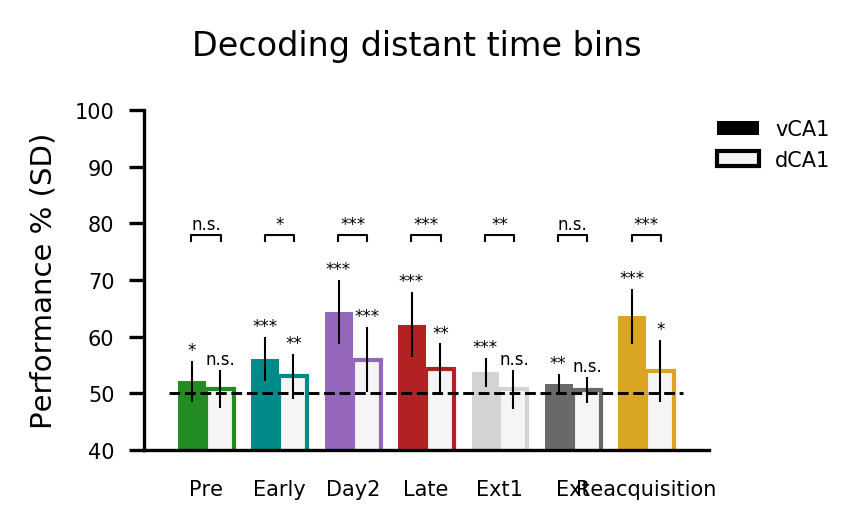

In [48]:
from matplotlib.patches import Patch
labels = session_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(sessions,dark_co,range(len(sessions))):
    v[sess] = np.array(np.std(beyond2s_all_means_vhpc[sess])*100)
    ax.bar(i - width/2, np.mean(beyond2s_all_means_vhpc[sess])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(beyond2s_all_means_dhpc[sess])*100)
    ax.bar(i + width/2,  np.mean(beyond2s_all_means_dhpc[sess])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,6.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
ax.set_ylim(40,100)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(sessions, range(len(sessions))):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[sess],
                                beyond2s_all_means_dhpc[sess],-.2+i,0.2+i,78))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,beyond2s_all_means_vhpc[sess],.5,-.2+i,
               np.mean(beyond2s_all_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,beyond2s_all_means_dhpc[sess],.5, .2+i,
               np.mean(beyond2s_all_means_dhpc[sess])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding distant time bins',y=1.06,fontsize=8)

fig.savefig('../final-ish figures/%s_decoding_distant_tbs_all.pdf'%NOTEBOOK_NAME)

In [12]:
PrPoExRe_sessions = 'pre','post','ext2','renew'
PrPoExRe_labels = 'Early','Late','Ext','Reacq'
PrPoExRe_colors = 'darkcyan','firebrick','dimgrey','goldenrod'

In [13]:
len(beyond2s_all_means_vhpc['post'])

22

pre U = 326.0 p = 0.0499999631908 r = 0.297245051407
None
post U = 409.0 p = 9.29892860958e-05 r = 0.59095147125
None
ext2 U = 322.5 p = 0.0603980923349 r = 0.284859840932
None
renew U = 415.0 p = 5.14307823647e-05 r = 0.612183260636
None


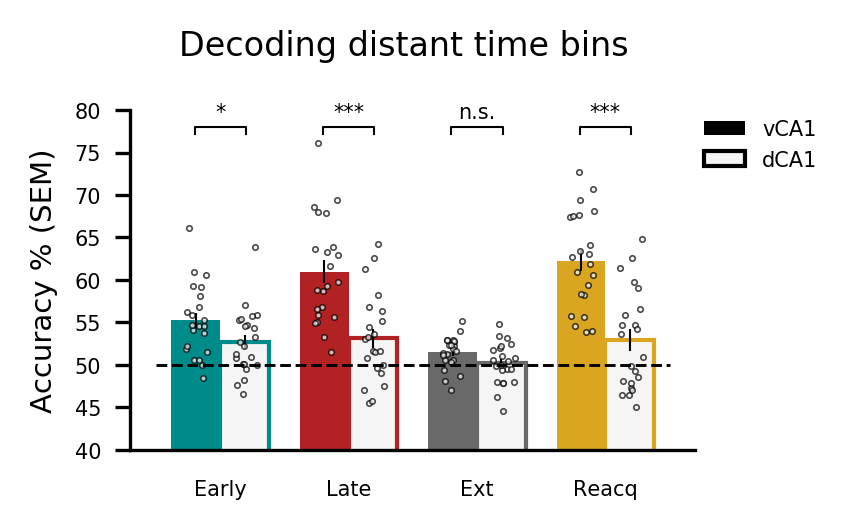

In [27]:
from matplotlib.patches import Patch
labels = PrPoExRe_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = len(beyond2s_all_means_vhpc['post'])
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(PrPoExRe_sessions,PrPoExRe_colors,range(len(PrPoExRe_colors))):
    v[sess] = np.array(np.std(beyond2s_all_means_vhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i - width/2, np.mean(beyond2s_all_means_vhpc[sess])*100, width, color=c,yerr=v[sess])
    ax.scatter(i-width/2+np.random.random(loops)*width/2-width/4.5,np.array(beyond2s_all_means_vhpc[sess])*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    d[sess] = np.array(np.std(beyond2s_all_means_dhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i + width/2,  np.mean(beyond2s_all_means_dhpc[sess])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
    ax.scatter(i+width/2+np.random.random(loops)*width/2-width/4.5,np.array(beyond2s_all_means_dhpc[sess])*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
ax.hlines(50,-.5,3.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
ax.set_ylim(40,80)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(PrPoExRe_sessions, range(len(PrPoExRe_sessions))):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[sess],
                                beyond2s_all_means_dhpc[sess],-.2+i,0.2+i,78))
    print sess,report_stats(beyond2s_all_means_vhpc[sess],beyond2s_all_means_dhpc[sess])
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    #pvs.append(sig_vs_chance(ax,beyond2s_all_means_vhpc[sess],.5,-.2+i,
    #           np.mean(beyond2s_all_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    #pvs.append(sig_vs_chance(ax,beyond2s_all_means_dhpc[sess],.5, .2+i,
    #           np.mean(beyond2s_all_means_dhpc[sess])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding distant time bins',y=1.06,fontsize=8)

fig.savefig('../final-ish figures/%s_decoding_distant_tbs_PrPoExRe.pdf'%NOTEBOOK_NAME)

In [25]:
PoExRe_sessions = ['post','ext2','renew']
PoExRe_labels = ['Late','Ext','Renew']
PoExRe_colors = ['firebrick','dimgrey','goldenrod']

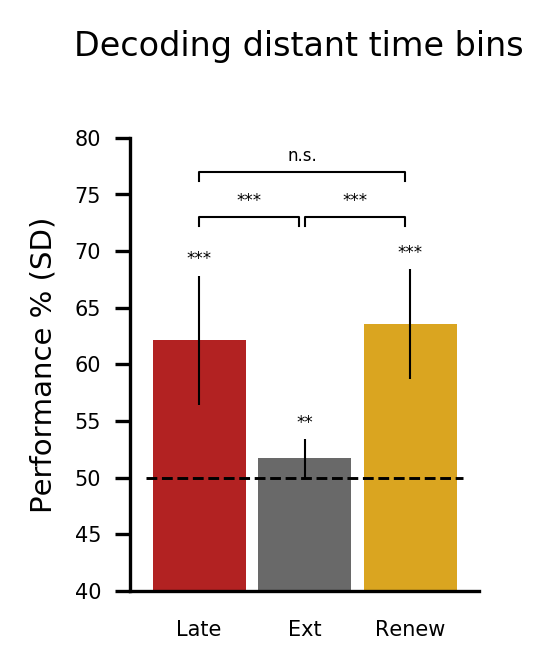

In [26]:
from matplotlib.patches import Patch
labels = PoExRe_labels
x = np.arange(len(labels))  # the label locations
width = 0.88  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots(figsize=(1.5,2))
for sess,c,i in zip(PoExRe_sessions,PoExRe_colors,range(len(PoExRe_sessions))):
    v[sess] = np.array(np.std(beyond2s_all_means_vhpc[sess])*100)
    ax.bar(i, np.mean(beyond2s_all_means_vhpc[sess])*100, width, color=c,yerr=v[sess])
ax.hlines(50,-.5,2.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
ax.set_ylim(40,80)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(PoExRe_sessions, range(len(PoExRe_sessions))):
    pvs.append(sig_vs_chance(ax,beyond2s_all_means_vhpc[sess],.5,i,
               np.mean(beyond2s_all_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
for i in range(2):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PoExRe_sessions[i]],
                                beyond2s_all_means_vhpc[PoExRe_sessions[i+1]],i,.95+i,73))
pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PoExRe_sessions[0]],
                                beyond2s_all_means_vhpc[PoExRe_sessions[2]],0,1.95,77))
pl.suptitle('Decoding distant time bins',y=1.06,fontsize=8)

#fig.savefig('../final-ish figures/%s_decoding_distant_tbs_all.pdf'%NOTEBOOK_NAME)

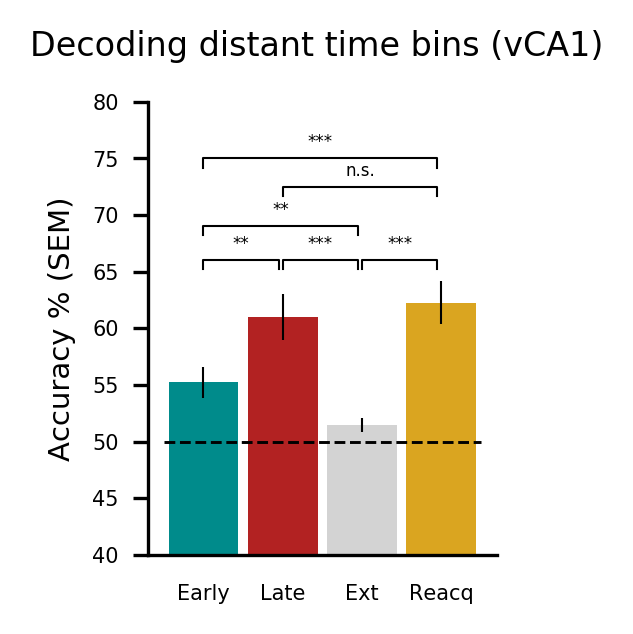

In [238]:
from matplotlib.patches import Patch
labels = 'Early','Late','Ext','Reacq'
x = np.arange(len(labels))  # the label locations
width = 0.88  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots(figsize=(1.5,2))
for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,4,6],range(4)):
    v[sess] = np.array(np.std(beyond2s_all_means_vhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i, np.mean(beyond2s_all_means_vhpc[sess])*100, width, color=dark_co[c],yerr=v[sess])
ax.hlines(50,-.5,3.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
ax.set_ylim(40,80)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
#for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,4,6],range(4)):
    #pvs.append(sig_vs_chance(ax,beyond2s_all_means_vhpc[sess],.5,i,
    #           np.mean(beyond2s_all_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
for i in range(3):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[i+1]],i,.95+i,66,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[i+2]],i,i+1.95,69+i*3.5,mcc=3))
pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[0]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[3]],0,2.95,75,mcc=3))
pl.suptitle('Decoding distant time bins (vCA1)',y=1,fontsize=8)

#fig.savefig('../final-ish figures/%s_decoding_distant_tbs_all.pdf'%NOTEBOOK_NAME)

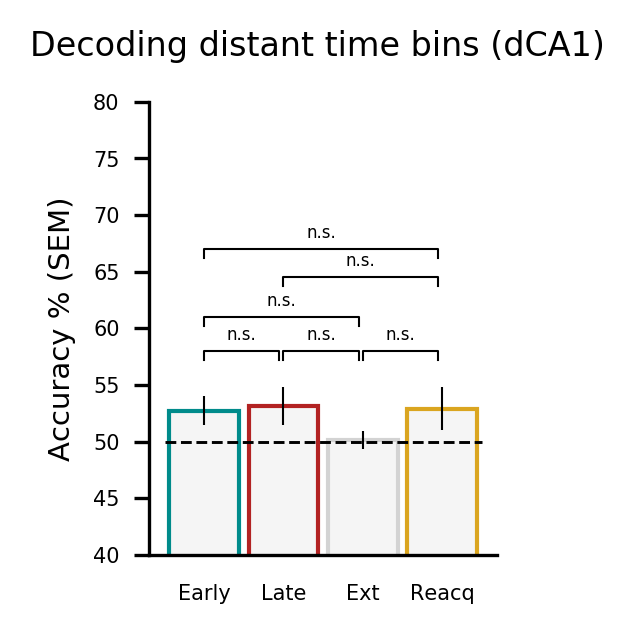

In [243]:
from matplotlib.patches import Patch
labels = 'Early','Late','Ext','Reacq'
x = np.arange(len(labels))  # the label locations
width = 0.88  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots(figsize=(1.5,2))
for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,4,6],range(4)):
    v[sess] = np.array(np.std(beyond2s_all_means_dhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i, np.mean(beyond2s_all_means_dhpc[sess])*100, width, color='whitesmoke',edgecolor=dark_co[c],yerr=v[sess])
ax.hlines(50,-.5,3.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
ax.set_ylim(40,80)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
#for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,4,6],range(4)):
    #pvs.append(sig_vs_chance(ax,beyond2s_all_means_dhpc[sess],.5,i,
    #           np.mean(beyond2s_all_means_dhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
for i in range(3):
    pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[i+1]],i,.95+i,66-8,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[i+2]],i,i+1.95,69-8+i*3.5,mcc=3))
pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[0]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[3]],0,2.95,75-8,mcc=3))
pl.suptitle('Decoding distant time bins (dCA1)',y=1,fontsize=8)

#fig.savefig('../final-ish figures/%s_decoding_distant_tbs_all.pdf'%NOTEBOOK_NAME)

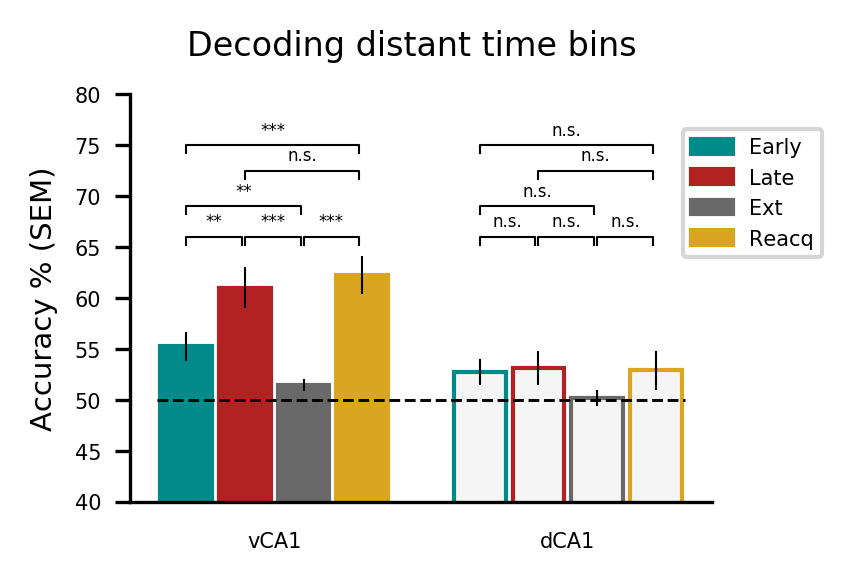

In [275]:
from matplotlib.patches import Patch
labels = 'Early','Late','Ext','Reacq'
x = np.arange(len(labels))  # the label locations
width = 0.88  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots(figsize=(2.5,1.8))
for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,5,6],range(4)):
    v[sess] = np.array(np.std(beyond2s_all_means_vhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i, np.mean(beyond2s_all_means_vhpc[sess])*100, width, color=dark_co[c],edgecolor=dark_co[c],yerr=v[sess],label=labels[i])
    d[sess] = np.array(np.std(beyond2s_all_means_dhpc[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i+5, np.mean(beyond2s_all_means_dhpc[sess])*100, width, color='whitesmoke',edgecolor=dark_co[c],yerr=d[sess])
ax.hlines(50,-.5,8.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
ax.set_ylim(40,80)
ax.legend(loc=(.95,.6))
#ax.set_title('Decoding During CS')
ax.set_xticks([1.5,6.5])
ax.set_xticklabels(['vCA1','dCA1'])
ax.tick_params(axis='x',bottom=False)
pvs=[]
for i in range(3):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[i+1]],i,.95+i,66,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[i+2]],i,i+1.95,69+i*3.5,mcc=3))
pvs.append(add_significance(ax, beyond2s_all_means_vhpc[PrPoExRe_sessions[0]],
                                beyond2s_all_means_vhpc[PrPoExRe_sessions[3]],0,2.95,75,mcc=3))

for i in range(3):
    pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[i+1]],i+5,5.95+i,66,mcc=3))
for i in range(2):
    pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[i]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[i+2]],i+5,i+6.95,69+i*3.5,mcc=3))
pvs.append(add_significance(ax, beyond2s_all_means_dhpc[PrPoExRe_sessions[0]],
                                beyond2s_all_means_dhpc[PrPoExRe_sessions[3]],5,7.95,75,mcc=3))
pl.suptitle('Decoding distant time bins',y=1,fontsize=8)

fig.savefig('../final-ish figures/%s_decoding_distant_tbs_d&v_PrPoExRe.pdf'%NOTEBOOK_NAME)

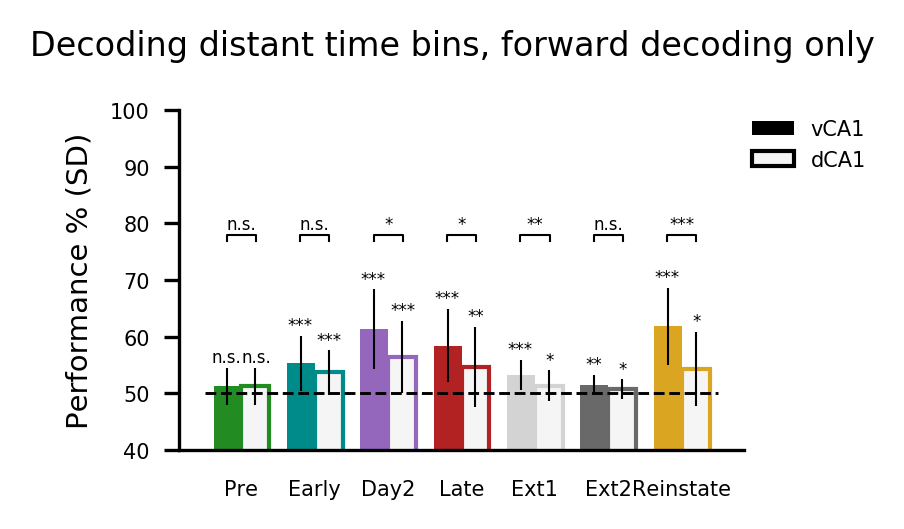

In [60]:
from matplotlib.patches import Patch
labels = session_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(sessions,dark_co,range(len(sessions))):
    v[sess] = np.array(np.std(beyond2s_forward_means_vhpc[sess])*100)
    ax.bar(i - width/2, np.mean(beyond2s_forward_means_vhpc[sess])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(beyond2s_forward_means_dhpc[sess])*100)
    ax.bar(i + width/2,  np.mean(beyond2s_forward_means_dhpc[sess])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,6.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
ax.set_ylim(40,100)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(sessions, range(len(sessions))):
    pvs.append(add_significance(ax, beyond2s_forward_means_vhpc[sess],
                                beyond2s_forward_means_dhpc[sess],-.2+i,0.2+i,78))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,beyond2s_forward_means_vhpc[sess],.5,-.2+i,
               np.mean(beyond2s_forward_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,beyond2s_forward_means_dhpc[sess],.5, .2+i,
               np.mean(beyond2s_forward_means_dhpc[sess])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding distant time bins, forward decoding only',y=1.06,fontsize=8)

fig.savefig('../final-ish figures/%s_decoding_distant_tbs_forward.pdf'%NOTEBOOK_NAME)

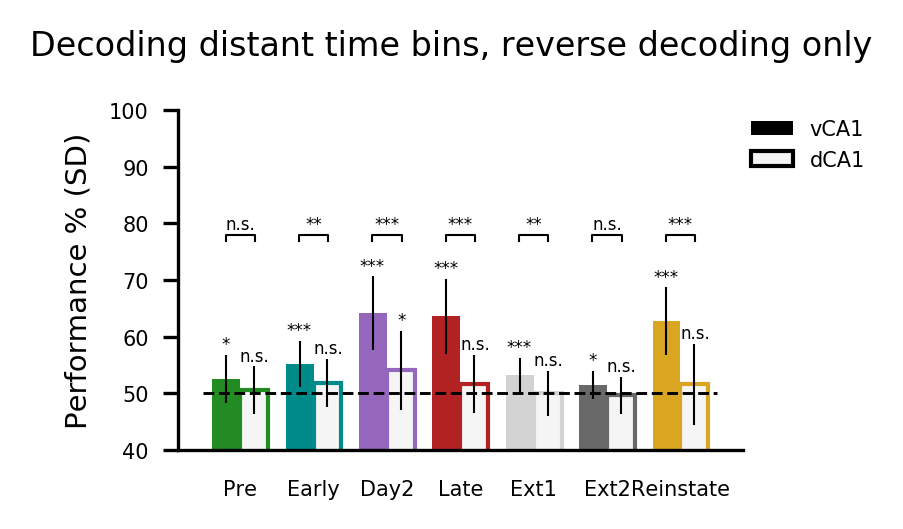

In [61]:
from matplotlib.patches import Patch
labels = session_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(sessions,dark_co,range(len(sessions))):
    v[sess] = np.array(np.std(beyond2s_reverse_means_vhpc[sess])*100)
    ax.bar(i - width/2, np.mean(beyond2s_reverse_means_vhpc[sess])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(beyond2s_reverse_means_dhpc[sess])*100)
    ax.bar(i + width/2,  np.mean(beyond2s_reverse_means_dhpc[sess])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,6.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
ax.set_ylim(40,100)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for sess,i in zip(sessions, range(len(sessions))):
    pvs.append(add_significance(ax, beyond2s_reverse_means_vhpc[sess],
                                beyond2s_reverse_means_dhpc[sess],-.2+i,0.2+i,78))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,beyond2s_reverse_means_vhpc[sess],.5,-.2+i,
               np.mean(beyond2s_reverse_means_vhpc[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,beyond2s_reverse_means_dhpc[sess],.5, .2+i,
               np.mean(beyond2s_reverse_means_dhpc[sess])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding distant time bins, reverse decoding only',y=1.06,fontsize=8)

fig.savefig('../final-ish figures/%s_decoding_distant_tbs_reverse.pdf'%NOTEBOOK_NAME)

### now taking mean of test/train, train/test runs

In [62]:
for r in 'dhpc','vhpc':
    for t in range (16):
        exec('distinct_mean%s_%s = {}'%(t,r))
    for sess in sessions:
        for t in range (16):
            exec("distinct_mean%s_%s['%s'] = []"%(t,r,sess))
            for c in range (16):
                #print eval('testy%s'%t)[sess]
                eval('distinct_mean%s_%s'%(t,r))[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,r))[sess].mean(1)).mean())

In [63]:
for r in 'dhpc','vhpc':
    for t in range (16):
        exec('distinct_mean%s_wilcox_%s = {}'%(t,r))
    for sess in sessions:
        for t in range (16):
            exec("distinct_mean%s_wilcox_%s['%s'] = []"%(t,r,sess))
            for c in range (16):
                exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s_%s[sess].mean(1)]"%(t,c,r))
                eval('distinct_mean%s_wilcox_%s'%(t,r))[sess].insert(c, sstats.wilcoxon(subtracted[:10]))
            for x,i in zip(eval('distinct_mean%s_wilcox_%s'%(t,r))[sess],range(len(eval('distinct_mean%s_wilcox_%s'%(t,r))[sess]))):
                exec("distinct_mean%s_wilcox_%s[sess][i] = x[-1]"%(t,r)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [64]:
for r in 'dhpc','vhpc':
    exec("distinct_mean_%s={}"%r)
    for sess in sessions:
        exec("distinct_mean_%s[sess]=(distinct_mean0_%s[sess], distinct_mean1_%s[sess], distinct_mean2_%s[sess], distinct_mean3_%s[sess], distinct_mean4_%s[sess], distinct_mean5_%s[sess], distinct_mean6_%s[sess], distinct_mean7_%s[sess],\
                     distinct_mean8_%s[sess], distinct_mean9_%s[sess], distinct_mean10_%s[sess], distinct_mean11_%s[sess], distinct_mean12_%s[sess], distinct_mean13_%s[sess], distinct_mean14_%s[sess], distinct_mean15_%s[sess])"%(r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,))
        exec("np.array([distinct_mean_%s[sess]])"%r)

In [65]:
for r in 'dhpc','vhpc':
    exec("distinct_mean_wilcox_%s={}"%r)
    for sess in sessions:
        exec("distinct_mean_wilcox_%s[sess]=(distinct_mean0_wilcox_%s[sess], distinct_mean1_wilcox_%s[sess], distinct_mean2_wilcox_%s[sess], distinct_mean3_wilcox_%s[sess], distinct_mean4_wilcox_%s[sess], distinct_mean5_wilcox_%s[sess], distinct_mean6_wilcox_%s[sess], distinct_mean7_wilcox_%s[sess],\
                     distinct_mean8_wilcox_%s[sess], distinct_mean9_wilcox_%s[sess], distinct_mean10_wilcox_%s[sess], distinct_mean11_wilcox_%s[sess], distinct_mean12_wilcox_%s[sess], distinct_mean13_wilcox_%s[sess], distinct_mean14_wilcox_%s[sess], distinct_mean15_wilcox_%s[sess])"%(r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,r,))
        exec("np.array([distinct_mean_wilcox_%s[sess]])"%r)

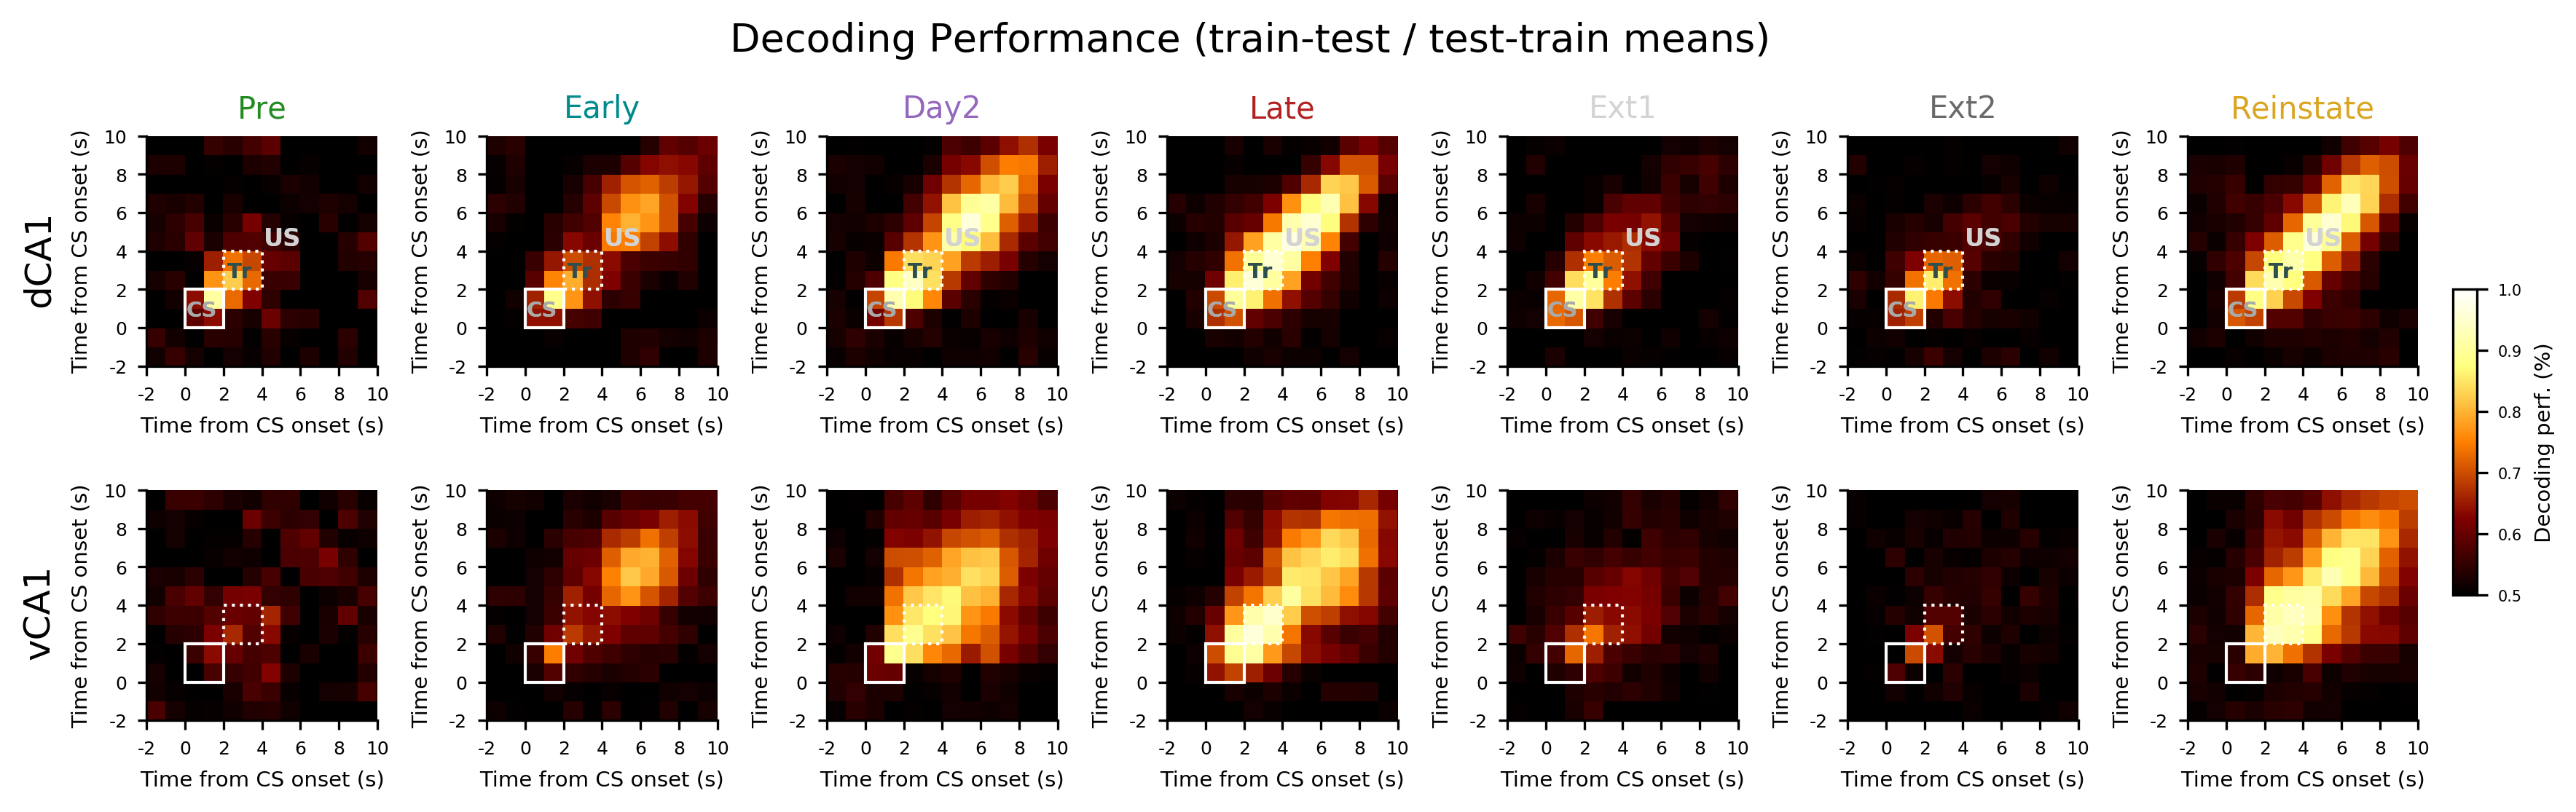

In [66]:
fig, ax = pl.subplots(2, 7, figsize=(11, 3.5))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for r,x in zip(['dhpc','vhpc'],range(2)):
    for sess,y in zip(sessions,range(len(sessions))):
        im = ax[x][y].pcolormesh(eval("distinct_mean_%s[sess]"%r),vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[x][y].axis('image')
    for y in range (7):
        ax[x][y].set_xticks(range(1,16,2))
        ax[x][y].set_yticks(range(1,16,2))
        ax[x][y].set_ylim(3, 15)
        ax[x][y].set_xlim(3, 15)
        ax[x][y].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[x][y].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
        ax[x][y].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[x][y].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[0][y].set_title(session_labels[y],fontsize=10,color=dark_co[y])
        ax[x][y].tick_params(length=3)
        ax[0][y].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='darkgrey')
        ax[0][y].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='darkslategrey')
        ax[0][y].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='lightgray')

import matplotlib.patches as patches
for y in range(7):
    for x in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='w',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[x][y].add_patch(CS)
        ax[x][y].add_patch(Tr)




pl.suptitle('Decoding Performance (train-test / test-train means)',y=1.05,fontsize=13)
ax[0][0].text(-3.5,9.7,'dCA1', rotation = 90, fontsize=12)
ax[1][0].text(-3.5,9.7,'vCA1', rotation = 90, fontsize=12)
cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_means_across_bins_dv.pdf'%NOTEBOOK_NAME)

In [67]:
for t in range (16):
    exec('distinct_mean%s_MannWhitney_dhpcVSvhpc = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct_mean%s_MannWhitney_dhpcVSvhpc['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct_mean%s_MannWhitney_dhpcVSvhpc'%t)[sess].insert(c,
                  sstats.mannwhitneyu(eval('scores_gmin_tb_distinct_%s_VS_%s_dhpc[sess].mean(1)[:10]'%(t,c)),
                  eval('scores_gmin_tb_distinct_%s_VS_%s_vhpc[sess].mean(1)[:10]'%(t,c)), alternative='two-sided'))
        for x,i in zip(eval('distinct_mean%s_MannWhitney_dhpcVSvhpc'%t)[sess],range(len(eval('distinct_mean%s_MannWhitney_dhpcVSvhpc'%t)[sess]))):
            exec("distinct_mean%s_MannWhitney_dhpcVSvhpc[sess][i] = x[-1]"%(t)) #only take p-values

In [68]:
distinct_mean_MannWhitney_dhpcVSvhpc={}
for sess in sessions:
    distinct_mean_MannWhitney_dhpcVSvhpc[sess]=(distinct_mean0_MannWhitney_dhpcVSvhpc[sess], distinct_mean1_MannWhitney_dhpcVSvhpc[sess], distinct_mean2_MannWhitney_dhpcVSvhpc[sess], distinct_mean3_MannWhitney_dhpcVSvhpc[sess],
                          distinct_mean4_MannWhitney_dhpcVSvhpc[sess], distinct_mean5_MannWhitney_dhpcVSvhpc[sess], distinct_mean6_MannWhitney_dhpcVSvhpc[sess], distinct_mean7_MannWhitney_dhpcVSvhpc[sess],
                          distinct_mean8_MannWhitney_dhpcVSvhpc[sess], distinct_mean9_MannWhitney_dhpcVSvhpc[sess], distinct_mean10_MannWhitney_dhpcVSvhpc[sess], distinct_mean11_MannWhitney_dhpcVSvhpc[sess],
                          distinct_mean12_MannWhitney_dhpcVSvhpc[sess], distinct_mean13_MannWhitney_dhpcVSvhpc[sess], distinct_mean14_MannWhitney_dhpcVSvhpc[sess], distinct_mean15_MannWhitney_dhpcVSvhpc[sess])
    np.array([distinct_mean_MannWhitney_dhpcVSvhpc[sess]])

In [69]:
import copy
distinct_mean_MannWhitney_dhpcVSvhpc_to_plot = copy.deepcopy(distinct_mean_MannWhitney_dhpcVSvhpc)

In [70]:
#code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
for sess in sessions:
    for i in range(len(distinct_mean_vhpc[sess])):
        for j in range(len(distinct_mean_vhpc[sess][i])):
            distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0
            if distinct_mean_vhpc[sess][i][j] > distinct_mean_dhpc[sess][i][j] and distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=-1
            if distinct_mean_vhpc[sess][i][j] < distinct_mean_dhpc[sess][i][j] and distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=1
            #else:
            #    distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

In [71]:
#code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
import math
for sess in sessions:
    for i in range(len(distinct_mean_vhpc[sess])):
        for j in range(len(distinct_mean_vhpc[sess][i])):
            distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0
            if distinct_mean_vhpc[sess][i][j] > distinct_mean_dhpc[sess][i][j] and distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]= (math.log10(distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j]))
            if distinct_mean_vhpc[sess][i][j] < distinct_mean_dhpc[sess][i][j] and distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j] < 0.05:
                distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]= -(math.log10(distinct_mean_MannWhitney_dhpcVSvhpc[sess][i][j]))
            #else:
            #    distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

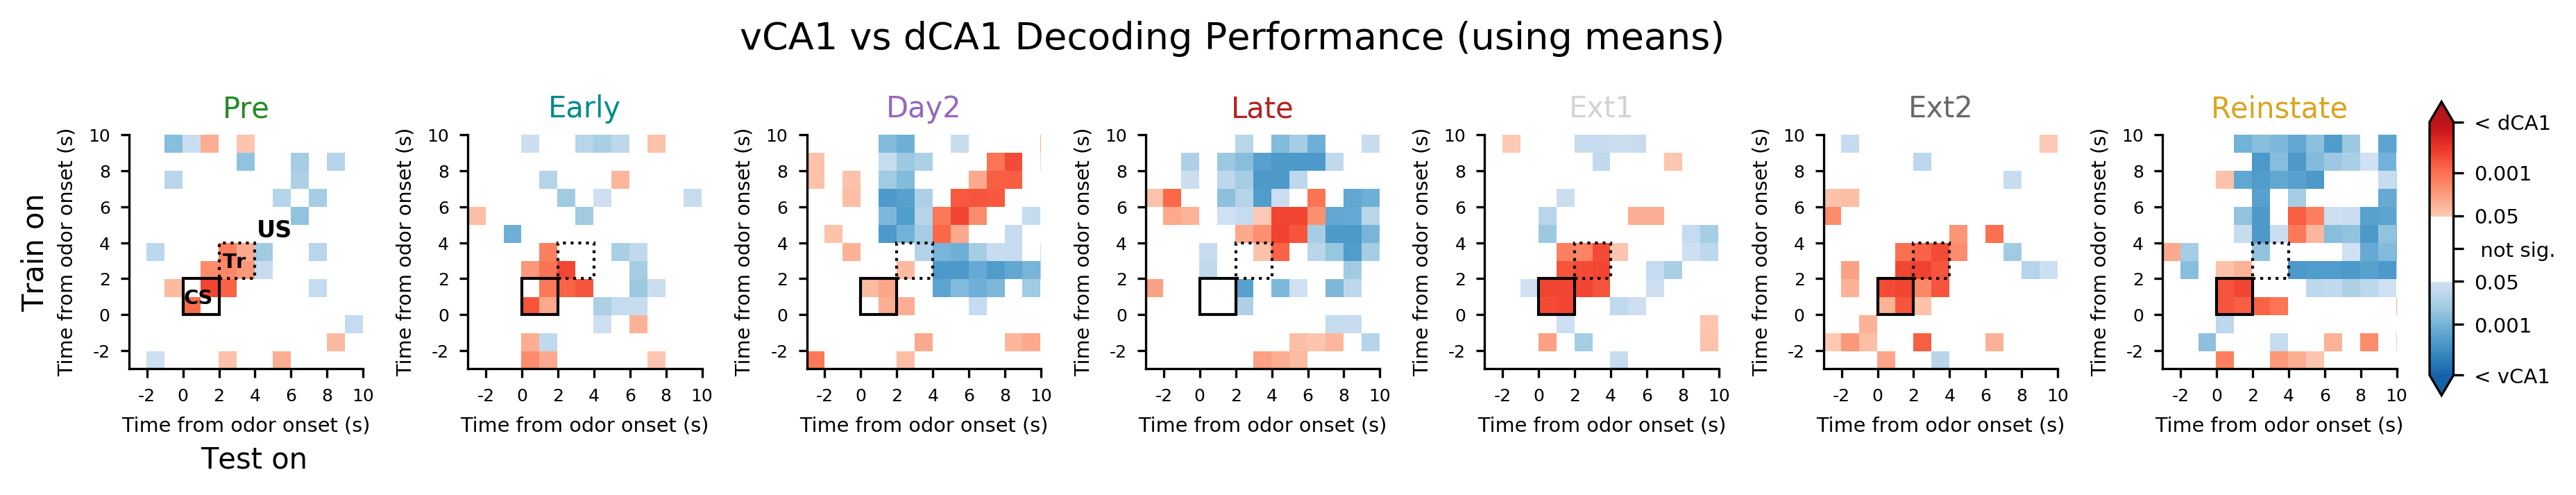

In [72]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
vsigs = cm.get_cmap('Blues', 80)
dsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)vmin=0.5
vmin=-5
vmax=5
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].pcolormesh(distinct_mean_MannWhitney_dhpcVSvhpc_to_plot[sess],vmax=vmax,vmin=vmin,
                      cmap=newcmap)
    ax[x].axis('image')
    #ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot[sess],vmin=vmin, vmax=vmax,
    #                  cmap='bwr')
for x in range (7):
    ax[x].set_xticks(range(1,16,2))
    ax[x].set_yticks(range(1,16,2))
    ax[x].set_ylim(2, 15)
    ax[x].set_xlim(2, 15)
    ax[x].set_xticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4', '6','8','10'],fontsize=6)
    ax[x].set_ylabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_xlabel('Time from odor onset (s)', fontsize=6.9)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75+.3,5.1+.5,"CS",fontsize=7, weight='bold', color='k')
ax[0].text(6.85+.35,7.1+.5,"Tr",fontsize=7, weight='bold', color='k')
ax[0].text(8.6+.5,8.8+.5,"US",fontsize=8, weight='bold', color='k')
ax[0].text(6,-3.5,"Test on", fontsize=10)
ax[0].text(-4,10.5,"Train on", fontsize=10, rotation=90)

pl.suptitle('vCA1 vs dCA1 Decoding Performance (using means)',y=.87,fontsize=13)

cax = fig.add_axes([1,0.27, 0.01, 0.47])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_gmin_mean_across_bins_mean_dVSv_Utest.pdf'%NOTEBOOK_NAME)

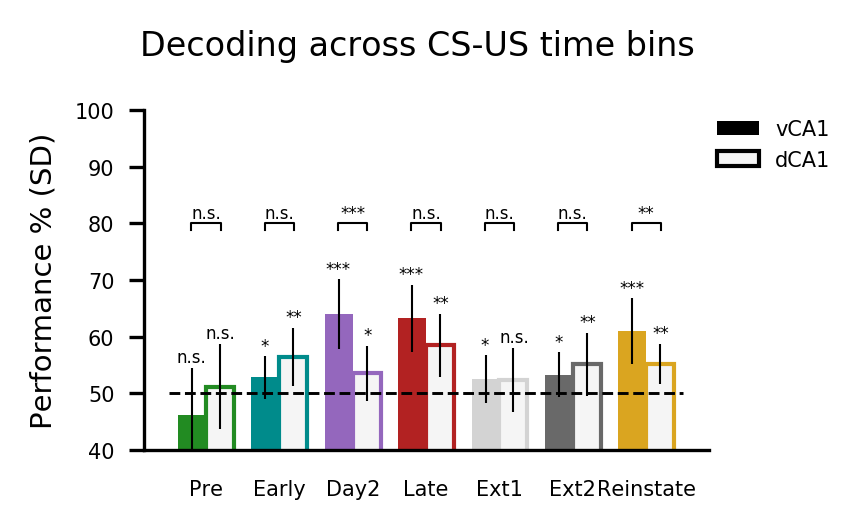

In [73]:
from matplotlib.patches import Patch
labels = session_labels
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 15
v={}
d={}

fig, ax = pl.subplots()
for sess,c,i in zip(sessions,dark_co,range(len(sessions))):
    v[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100)
    ax.bar(i - width/2, np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100)
    ax.bar(i + width/2,  np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,6.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
ax.set_ylim(40,100)


pvs=[]
for sess,i in zip(sessions, range(len(sessions))):
    pvs.append(add_significance(ax, scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops],
                                scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops],-.2+i,0.2+i,80))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops],.5,-.2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops],.5, .2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding across CS-US time bins',y=1.06,fontsize=8)

fig.savefig('../img/%s_decodingUSfromCS_mean_allsess.pdf'%NOTEBOOK_NAME)

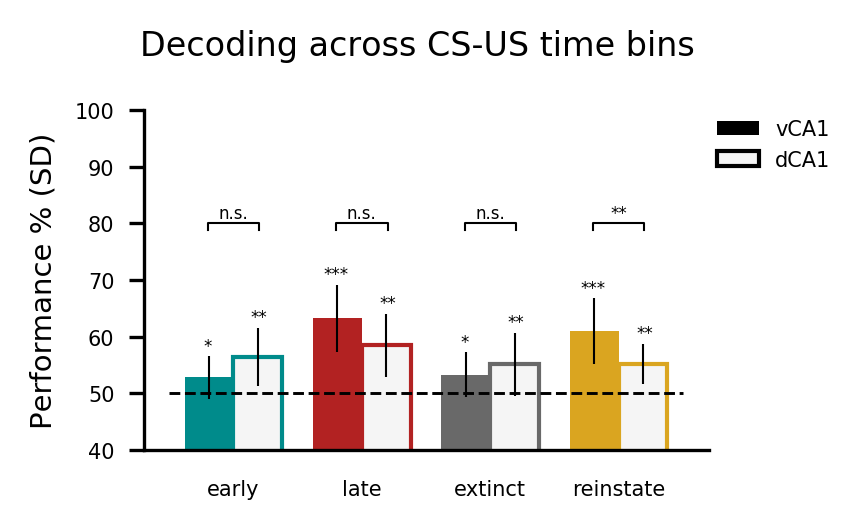

In [74]:
from matplotlib.patches import Patch
labels = 'early','late','extinct','reinstate'
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 15
v={}
d={}
fig_sessions = 'pre','post','ext2','renew'
fig_co = dark_co[1],dark_co[3],dark_co[5],dark_co[6]

fig, ax = pl.subplots()
for sess,c,i in zip(fig_sessions,fig_co,range(len(fig_sessions))):
    v[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100)
    ax.bar(i - width/2, np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100, width, color=c,yerr=v[sess])
    d[sess] = np.array(np.std(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100)
    ax.bar(i + width/2,  np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
ax.hlines(50,-.5,3.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance % (SD)')
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
ax.set_ylim(40,100)


pvs=[]
for sess,i in zip(fig_sessions, range(len(fig_sessions))):
    pvs.append(add_significance(ax, scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops],
                                scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops],-.2+i,0.2+i,80))
        #max(np.mean(mean_scores_gmin_tb_6_vhpc[sess][:loops])*100+v[sess],
        #    np.mean(mean_scores_gmin_tb_6_dhpc[sess][:loops])*100+d[sess])+6))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops],.5,-.2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_vhpc[sess].mean(1)[:loops])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
    pvs.append(sig_vs_chance(ax,scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops],.5, .2+i,
               np.mean(scores_gmin_tb_distinct_6_VS_10_dhpc[sess].mean(1)[:loops])*100+d[sess]+1,loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding across CS-US time bins',y=1.06,fontsize=8)

fig.savefig('../img/%s_decodingUSfromCS_mean_fig.jpg'%NOTEBOOK_NAME)

# 2s data

In [75]:
for r in 'dhpc','vhpc':
    #exec("distinct_%s = {}"%r)
    exec("distinct_%s_2s = ut.load_variable('distinct',\
        '../notebooks/autorestore/decoding_around_onset_combined_2sec_%s/')"%(r,r))

In [76]:
for r in 'dhpc','vhpc':
    for t in range (7):
        for c in range (7):
            exec('scores_gmin_tb_distinct_%s_VS_%s_%s_2s = {}'%(t,c,r))
            for sess in sessions:
                exec("scores_gmin_tb_distinct_%s_VS_%s_%s_2s = ut.load_variable('scores_gmin_tb_distinct_%s_VS_%s',\
                     '../notebooks/autorestore/decoding_around_onset_combined_2sec_%s/')"%(t,c,r,t,c,r))

In [77]:
for t in range (7):
    exec('distinct%s_MannWhitney_dhpcVSvhpc_2s = {}'%t)
for sess in sessions:
    for t in range (7):
        exec("distinct%s_MannWhitney_dhpcVSvhpc_2s['%s'] = []"%(t,sess))
        for c in range (7):
            eval('distinct%s_MannWhitney_dhpcVSvhpc_2s'%t)[sess].insert(c,
                  sstats.mannwhitneyu(eval('scores_gmin_tb_distinct_%s_VS_%s_dhpc_2s[sess].mean(1)[:15]'%(t,c)),
                  eval('scores_gmin_tb_distinct_%s_VS_%s_vhpc_2s[sess].mean(1)[:15]'%(t,c)), alternative='two-sided'))
        for x,i in zip(eval('distinct%s_MannWhitney_dhpcVSvhpc_2s'%t)[sess],range(len(eval('distinct%s_MannWhitney_dhpcVSvhpc_2s'%t)[sess]))):
            exec("distinct%s_MannWhitney_dhpcVSvhpc_2s[sess][i] = x[-1]"%(t)) #only take p-values

KeyError: 'd2'

In [ ]:
distinct_MannWhitney_dhpcVSvhpc_2s={}
for sess in sessions:
    distinct_MannWhitney_dhpcVSvhpc_2s[sess]=(distinct0_MannWhitney_dhpcVSvhpc_2s[sess],
    distinct1_MannWhitney_dhpcVSvhpc_2s[sess], distinct2_MannWhitney_dhpcVSvhpc_2s[sess],
    distinct3_MannWhitney_dhpcVSvhpc_2s[sess], distinct4_MannWhitney_dhpcVSvhpc_2s[sess],
    distinct5_MannWhitney_dhpcVSvhpc_2s[sess], distinct6_MannWhitney_dhpcVSvhpc_2s[sess])
    np.array([distinct_MannWhitney_dhpcVSvhpc_2s[sess]])

In [ ]:
import copy
distinct_MannWhitney_dhpcVSvhpc_to_plot_2s = copy.deepcopy(distinct_MannWhitney_dhpcVSvhpc_2s)

In [ ]:
#code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
for sess in sessions:
    for i in range(len(distinct_vhpc_2s[sess])):
        for j in range(len(distinct_vhpc_2s[sess][i])):
            distinct_MannWhitney_dhpcVSvhpc_to_plot_2s[sess][i][j]=0
            if distinct_vhpc_2s[sess][i][j] > distinct_dhpc_2s[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc_2s[sess][i][j] < 0.05:
                distinct_MannWhitney_dhpcVSvhpc_to_plot_2s[sess][i][j]=-1
            if distinct_vhpc_2s[sess][i][j] < distinct_dhpc_2s[sess][i][j] and distinct_MannWhitney_dhpcVSvhpc_2s[sess][i][j] < 0.05:
                distinct_MannWhitney_dhpcVSvhpc_to_plot_2s[sess][i][j]=1

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


fig, ax = pl.subplots(1, 6, figsize=(10, 3))#, sharex=True, sharey=True)
vmin=-1
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    ax[x].pcolormesh(distinct_MannWhitney_dhpcVSvhpc_to_plot_2s[sess],vmin=vmin, vmax=vmax,
                      cmap='bwr')
for x in range (0,6):
    ax[x].set_xticks(range(7))
    ax[x].set_yticks(range(7))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-4','-2','CS','Tr','US','6','8'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','CS','Tr','US','6','8'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=2.5)
    ax[x].axis('image')
    ax[x].text(2,2.25,"CS",fontsize=8, weight='bold', color='w')
    ax[2].text(2,2.25,"CS",fontsize=8, weight='bold', color='k')


#import matplotlib.patches as patches
#for x in range(6):
## Create a Rectangle patch
#    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
#    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.25,edgecolor='k',facecolor='none',linestyle=':')
## Add the patch to the Axes
#    ax[x].add_patch(CS)
#    ax[x].add_patch(Tr)
#

#ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
#ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.legend([Patch(facecolor='b'),Patch(facecolor='r'),Patch(facecolor='w',edgecolor='k')],
          ['vCA1>','dCA1>','not sig'],loc=(1,.5),frameon=False,fontsize=10)

pl.suptitle('vCA1 vs dCA1 decoding accuracy (2s bins)',y=.87,fontsize=13)

#cax = fig.add_axes([1,0.3, 0.01, 0.4])
#fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_gmin_across_bins_dVSv_Utest_2s.pdf'%NOTEBOOK_NAME)

In [78]:
save_workspace(db)

Could not store variable 'patches'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'copy'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'math'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'np'. Skipping...
